# Variant Interpretation Benchmark
This notebook shows results reported in paper **A Machine Learning approach to support ACMG/AMP-based Genomic Variant Classification** by G. Nicora et al.


*Genomic variant interpretation is a critical step of the diagnostic procedure, often supported by the application of tools that may predict the damaging impact of each variant or provide a guidelines-based classification.
We propose the application of Machine Learning methodologies, in particular Logistic Regression, to support variant classification and prioritization. Our approach combines ACMG/AMP guidelines for germline variant interpretation as well as variant annotation features and provides a probabilistic score of pathogenicity, thus supporting the prioritization and classification of variants that would be interpreted as uncertain by the ACMG/AMP guidelines. We compared different approaches in terms of variant prioritization and classification on different datasets, showing that our data-driven approach is able to solve more VUS cases in comparison with guidelines-based approaches and in silico prediction tools.*

Data are available in figshare

To open with Colab from Github, follow instructions in https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb


## Aim
Compare performance of different tools in variant classification and prioritization. In particular, we compared:
- Logistic Regression on ACMG/AMP criteria (LR-A)
- Logistic Regression on ACMG/AMP criteria and annotation features (LR-B)
- VVP [1]
- CADD [2]
- eVAI Pathogenicity Score (PS) [3]
- Bayesian score based on ACMG/AMP guidelines [5]
 
 **Requirements**
- Pytho 3.6.9
- Pandas 0.24.2
- scikit-learn 0.21.3


In [ ]:
from google.colab import drive
ROOT_PATH = '/content/drive'
drive.mount(ROOT_PATH)
# use your path here 
ROOT_PATH += ''
!pip install pydrive                             # Package to use Google Drive API - not installed in Colab VM by default


# Dependecies
!pip install pandas==0.24.2
!pip install numpy==1.17.4
!pip install scikit-learn==0.21.3
!pip install scipy==1.4.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth                    #

# change path to utils 
!cp "utils.py" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python --version

Python 3.7.12


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import *
from collections import Counter

In [ ]:
from utils import *

# Function to calculate the eVai pathogenicity score (PS)
def calc_patho_score(dataset):
    acmg_col = ['nPVS', 'nPS', 'nPM', 'nPP', 'nBA', 'nBS', 'nBP']
    return 4*dataset.nPVS+3*dataset.nPS+2*dataset.nPM+dataset.nPP-1.5*dataset.nBA-dataset.nBS-0.5*dataset.nBP

## Logistic Regression Training

ML training is performed based on benign and pathogenic variants reported without conflicting interpretation in CLINVITAE (http://clinvitae.invitae.com) up to 2017 (ClinVar variants were removed). 60% of the dataset is used for model selection and training (*Train set*), 30% is used to select the best classification threshold to maximize precision (*Probability tuning set*), 10% (*Test set*) is used to evaluate the performance also in comparison with the eVai Pathogenicity Score (PS) [3].

In [ ]:
# Loading variants in the Training set, Probability tuning set and Test set
train_path = ROOT_PATH + 'pubblication_data/clinvitae2017/2017_03_ClinvitaeTrueClass_Train_60.tsv'
test_path = ROOT_PATH + 'pubblication_data/clinvitae2017/2017_03_ClinvitaeTrueClass_Test_30.tsv'
val_path = ROOT_PATH + '/pubblication_data/clinvitae2017/2017_03_ClinvitaeTrueClass_Validation_10.tsv'

train_var = pd.read_csv(train_path, sep='\t')
tuning_var = pd.read_csv(test_path, sep='\t')
test_var = pd.read_csv(val_path, sep='\t')

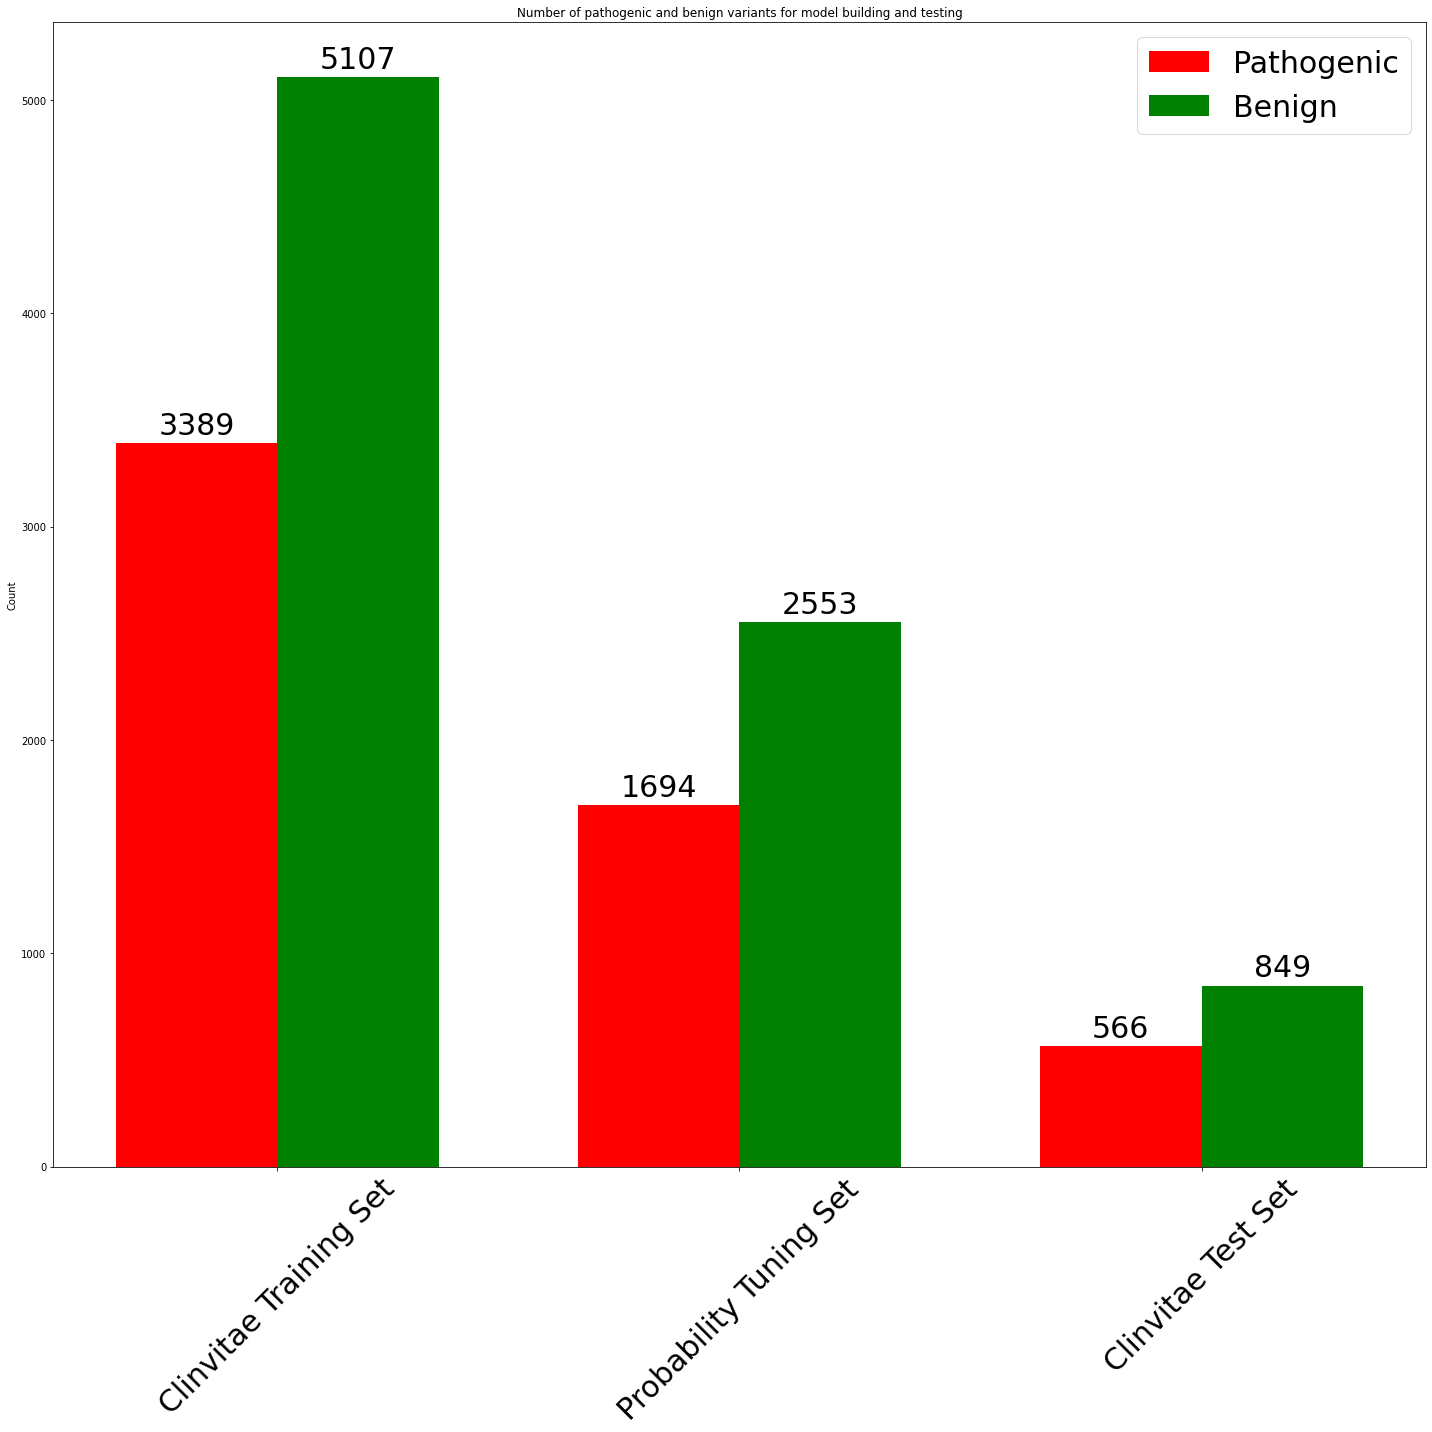

In [ ]:
labels = ['Clinvitae Training Set', 'Probability Tuning Set', 'Clinvitae Test Set']
patho_count = [train_var[train_var.FINAL_CLASSIFICATION=='Pathogenic'].shape[0],
               tuning_var[tuning_var.FINAL_CLASSIFICATION=='Pathogenic'].shape[0],
               test_var[test_var.FINAL_CLASSIFICATION=='Pathogenic'].shape[0]
               ]
ben_count = [train_var[train_var.FINAL_CLASSIFICATION=='Benign'].shape[0],
               tuning_var[tuning_var.FINAL_CLASSIFICATION=='Benign'].shape[0],
               test_var[test_var.FINAL_CLASSIFICATION=='Benign'].shape[0]
               ]
x = np.arange(len(labels))  # the label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(20,20))
rects1 = ax.bar(x - width/2, patho_count, width, label='Pathogenic', color='red')
rects2 = ax.bar(x + width/2, ben_count, width, label='Benign', color='green')

ax.set_ylabel('Count')
ax.set_title('Number of pathogenic and benign variants for model building and testing')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, fontsize=30)
ax.legend(fontsize=30)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=30)
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

In [ ]:
# Loading Clinvitae variants annotated with eVai
ann_path = ROOT_PATH + 'pubblication_data/clinvitae2017/2017_03_Clinvitae_annotated_dataset.tsv'
clinvitae_anno = pd.read_csv(ann_path, sep='\t')
kcol = ["CHROMOSOME", "START", "REF", "ALT"]
training_df = pd.merge(clinvitae_anno, train_var[kcol], left_on=kcol, right_on=kcol).drop_duplicates()
tuning_df = pd.merge(clinvitae_anno, tuning_var[kcol], left_on=kcol, right_on=kcol).drop_duplicates()
test_df = pd.merge(clinvitae_anno, test_var[kcol], left_on=kcol, right_on=kcol).drop_duplicates()


In [ ]:
# Known classes
y_train = pd.merge(training_df[kcol], train_var, left_on=kcol, right_on=kcol)['FINAL_CLASSIFICATION']
y_tuning = pd.merge(tuning_df[kcol], tuning_var, left_on=kcol, right_on=kcol)['FINAL_CLASSIFICATION']
y_test = pd.merge(test_df[kcol], test_var, left_on=kcol, right_on=kcol)['FINAL_CLASSIFICATION']

class_dict = {'Benign':0, 'Pathogenic':1}
y_train_num = [class_dict[x] for x in y_train]
y_tuning_num = [class_dict[x] for x in y_tuning]
y_test_num = [class_dict[x] for x in y_test]

In [ ]:
# ACMG features for A approach
col_A = ['nPVS', 'nPS', 'nPM', 'nPP', 'nBA', 'nBS', 'nBP']
# Annotation features + ACMG features for B approach
col_B = [x for x in training_df.columns if x not in kcol]

Now we train two Logistic regressions (LR-A and LR-B) on the training data. The best set of parameters is chosen with a nested cross validation.

In [ ]:
training_df.describe()

,START,nPVS,nPS,nPM,nPP,nBA,nBS,nBP,stop_gained,stop_lost,frameshift_variant,start_lost,exon_loss,exon_loss_variant,splice_acceptor_variant,splice_donor_variant,disruptive_inframe_insertion,disruptive_inframe_deletion,inframe_insertion,inframe_deletion,missense_variant,initiator_codon_variant,splice_region_variant,start_retained,non_canonical_start_codon,stop_retained_variant,synonymous_variant,exon_variant,transcript,intron_variant,5_prime_UTR_premature_start_codon_gain_variant,3_prime_UTR_truncation,5_prime_UTR_truncation,5_prime_UTR_variant,3_prime_UTR_variant,intragenic_variant,intergenic_region,upstream_gene_variant,downstream_gene_variant,RepeatMasker,ExAC_AF,ExAC_isTarget,gnomAD_WGS__gnomAD_WES_AF_ALL,gnomAD_WGS__gnomAD_WES_Hom_ALL,DBSNP_1TGP_ALT_freq,ESP6500SIv2_All_freq,DANN_score,dbscSNV_AB_score,dbscSNV_RF_score,PaPI_score,PolyPhen-2_score,SIFT_score,PseeAC-RF_score,HotSpot
count,8.496000e+03,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.0,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.0,8496.0,8496.000000,8496.000000,8496.0,8496.000000,8496.000000,8496.000000,8496.0,8496.000000,8496.000000,8496.000000,8496.000000,8496.0,8496.0,8496.0,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.00000,8496.000000,8496.000000,8496.000000,8496.000000
mean,8.194855e+07,0.207156,0.242938,0.498823,0.825212,0.187029,0.059793,0.735523,0.070537,0.000844,0.099331,0.001324,0.0,0.000349,0.015617,0.019471,0.002786,0.004375,0.000726,0.003296,0.304602,0.000147,0.068299,0.0,0.0,0.000177,0.184226,0.0,0.000098,0.247460,0.001695,0.0,0.000039,0.018432,0.014674,0.050388,0.0,0.0,0.0,0.026130,0.066545,0.993879,0.065895,4698.908310,0.071763,0.039625,0.677514,0.050877,0.048542,0.42738,-0.033932,-0.165620,0.461450,0.111464
std,5.861553e+07,0.405292,0.429980,0.717558,0.893732,0.389958,0.237117,0.958265,0.238597,0.026990,0.281012,0.033622,0.0,0.014190,0.118056,0.131181,0.050491,0.062619,0.024717,0.053419,0.427908,0.011183,0.241604,0.0,0.0,0.012129,0.364577,0.0,0.005271,0.378976,0.023887,0.0,0.003616,0.099528,0.094311,0.148195,0.0,0.0,0.0,0.159531,0.182395,0.077999,0.181488,17953.993509,0.193732,0.099375,0.362858,0.216944,0.198864,0.48539,0.635460,0.502796,0.463605,0.314725
min,1.932450e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.00000,-1.000000,-1.000000,-1.000000,0.000000
25%,3.783053e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.478555,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,6.470168e+07,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000832,1.000000,0.000873,1.000000,0.001198,0.000568,0.813192,0.000000,0.000000,0.01600,0.000000,0.000000,0.349000,0.000000
75%,1.287224e+08,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.541667,0.000000,0.000000

In [ ]:
training_df=training_df_notscaled

In [ ]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
training_df_notscaled = training_df.copy()
scaler = MinMaxScaler()
train_scaled_dataset = scaler.fit_transform(training_df[col_A+col_B])
training_df[col_A+col_B] = train_scaled_dataset

In [ ]:
training_df.describe()

,START,nPVS,nPS,nPM,nPP,nBA,nBS,nBP,stop_gained,stop_lost,frameshift_variant,start_lost,exon_loss,exon_loss_variant,splice_acceptor_variant,splice_donor_variant,disruptive_inframe_insertion,disruptive_inframe_deletion,inframe_insertion,inframe_deletion,missense_variant,initiator_codon_variant,splice_region_variant,start_retained,non_canonical_start_codon,stop_retained_variant,synonymous_variant,exon_variant,transcript,intron_variant,5_prime_UTR_premature_start_codon_gain_variant,3_prime_UTR_truncation,5_prime_UTR_truncation,5_prime_UTR_variant,3_prime_UTR_variant,intragenic_variant,intergenic_region,upstream_gene_variant,downstream_gene_variant,RepeatMasker,ExAC_AF,ExAC_isTarget,gnomAD_WGS__gnomAD_WES_AF_ALL,gnomAD_WGS__gnomAD_WES_Hom_ALL,DBSNP_1TGP_ALT_freq,ESP6500SIv2_All_freq,DANN_score,dbscSNV_AB_score,dbscSNV_RF_score,PaPI_score,PolyPhen-2_score,SIFT_score,PseeAC-RF_score,HotSpot
count,8.496000e+03,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.0,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.0,8496.0,8496.000000,8496.000000,8496.0,8496.000000,8496.000000,8496.000000,8496.0,8496.000000,8496.000000,8496.000000,8496.000000,8496.0,8496.0,8496.0,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000,8496.000000
mean,8.194855e+07,0.207156,0.121469,0.166274,0.275071,0.187029,0.059793,0.183881,0.070537,0.000844,0.099331,0.001324,0.0,0.000465,0.015617,0.019471,0.002786,0.004375,0.000726,0.003296,0.304602,0.000147,0.068299,0.0,0.0,0.000177,0.184226,0.0,0.000294,0.247460,0.003390,0.0,0.000118,0.018432,0.014674,0.050388,0.0,0.0,0.0,0.026130,0.066545,0.993879,0.065895,0.033896,0.071763,0.065410,0.677772,0.050877,0.048542,0.713690,0.483034,0.417190,0.730725,0.111464
std,5.861553e+07,0.405292,0.214990,0.239186,0.297911,0.389958,0.237117,0.239566,0.238597,0.026990,0.281012,0.033622,0.0,0.018920,0.118056,0.131181,0.050491,0.062619,0.024717,0.053419,0.427908,0.011183,0.241604,0.0,0.0,0.012129,0.364577,0.0,0.015813,0.378976,0.047775,0.0,0.010849,0.099528,0.094311,0.148195,0.0,0.0,0.0,0.159531,0.182395,0.077999,0.181488,0.129512,0.193732,0.164041,0.362996,0.216944,0.198864,0.242695,0.317730,0.251398,0.231802,0.314725
min,1.932450e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.783053e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.478737,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.000000
50%,6.470168e+07,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000832,1.000000,0.000873,0.000007,0.001198,0.000938,0.813501,0.000000,0.000000,0.508000,0.500000,0.500000,0.674500,0.000000
75%,1.287224e+08,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.541667,0.000000,0.000000,0.0,0.

In [ ]:
scoring = {'accuracy_score': make_scorer(accuracy_score),
           'precision_score': make_scorer(precision_score),
           'roc_auc_score': make_scorer(roc_auc_score), 'f1_score': make_scorer(f1_score),
           'recall': make_scorer(recall_score),  # Sensibility, tpr
           'balanced_accuracy_score': make_scorer(balanced_accuracy_score),
           'matthews_corrcoef': make_scorer(matthews_corrcoef),
           #'confusion_matrix': make_scorer(confusion_matrix),
           'average_precision_score': make_scorer(average_precision_score)}

p_grid = {"C":[0.5, 0.7, 1],
          "penalty":['l1', 'l2'],
          "solver":['liblinear']}

n_inner = 5
n_outer = 5
random_state = 1
np.random.seed(random_state)

inner_cv = StratifiedKFold(n_splits=n_inner, shuffle=False, random_state=random_state)
outer_cv = StratifiedKFold(n_splits=n_outer, shuffle=False, random_state=random_state)

# Parameter search and scoring: select the best model based on inner_cv
clfA = GridSearchCV(estimator=LogisticRegression(random_state=1), param_grid=p_grid, cv=inner_cv, n_jobs=-1)
clfA.fit(training_df[col_A], y_train_num)
# Outer CV for model performance:
crossval_scores_A = cross_validate(clfA, X=training_df[col_A], y=y_train_num, cv=outer_cv, scoring=scoring, n_jobs=-1,
                        return_train_score=False)
clfB = GridSearchCV(estimator=LogisticRegression(random_state=1), param_grid=p_grid, cv=inner_cv, n_jobs=-1)
clfB.fit(training_df[col_B], y_train_num)
# Outer CV for model performance:
crossval_scores_B = cross_validate(clfB, X=training_df[col_B], y=y_train_num, cv=outer_cv, scoring=scoring, n_jobs=-1,
                        return_train_score=False)


In [ ]:

clfA.best_estimator_



LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:

clfB.best_estimator_


LogisticRegression(C=0.7, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Cross Validation Results

Results on the 5 fold cross validation for the two logistic regression models

In [ ]:
pd.DataFrame(crossval_scores_A)

,fit_time,score_time,test_accuracy_score,test_precision_score,test_roc_auc_score,test_f1_score,test_recall,test_balanced_accuracy_score,test_matthews_corrcoef,test_average_precision_score
0,0.754664,0.019966,0.977647,0.974777,0.976196,0.971893,0.969027,0.976196,0.953351,0.956938
1,0.770774,0.057526,0.971765,0.977273,0.968325,0.964126,0.951327,0.968325,0.941086,0.949118
2,0.769832,0.020063,0.979988,0.961318,0.981615,0.975291,0.989676,0.981615,0.958768,0.955513
3,0.766251,0.038801,0.983520,0.986527,0.981581,0.979198,0.971976,0.981581,0.965627,0.970064
4,0.421437,0.020941,0.979388,0.970674,0.979127,0.974246,0.977843,0.979127,0.957082,0.958002


In [ ]:
pd.DataFrame(crossval_scores_B)

,fit_time,score_time,test_accuracy_score,test_precision_score,test_roc_auc_score,test_f1_score,test_recall,test_balanced_accuracy_score,test_matthews_corrcoef,test_average_precision_score
0,2.769339,0.023638,0.980588,0.984962,0.978146,0.975428,0.966077,0.978146,0.959511,0.965079
1,2.996119,0.063701,0.972353,0.986133,0.967573,0.964582,0.943953,0.967573,0.942532,0.953215
2,2.749753,0.040976,0.987051,0.975362,0.987988,0.983918,0.992625,0.987988,0.973187,0.971112
3,2.932775,0.062013,0.982343,0.987952,0.979858,0.977645,0.967552,0.979858,0.963200,0.968843
4,2.106368,0.020481,0.984099,0.983631,0.982796,0.979985,0.976366,0.982796,0.966814,0.969807


In [ ]:
# Mean and Std of different metrics across cross validation score
# A approach
results_crossval_A_mean = dict(zip([x+'_mean' for x in crossval_scores_A.keys()],
                                   [np.mean(crossval_scores_A[x]) for x in crossval_scores_A.keys()]))
results_crossval_A_std = dict(zip([x+'_std' for x in crossval_scores_A.keys()], [np.std(crossval_scores_A[x]) for x in crossval_scores_A.keys()]))

results_crossval_A = results_crossval_A_mean
results_crossval_A.update(results_crossval_A_std)

In [ ]:
# B approach
results_crossval_B_mean = dict(zip([x+'_mean' for x in crossval_scores_B.keys()],
                                   [np.mean(crossval_scores_B[x]) for x in crossval_scores_B.keys()]))
results_crossval_B_std = dict(zip([x+'_std' for x in crossval_scores_B.keys()], [np.std(crossval_scores_B[x]) for x in crossval_scores_B.keys()]))

results_crossval_B = results_crossval_B_mean
results_crossval_B.update(results_crossval_B_std)

In [ ]:
results_cross_val = pd.DataFrame.from_dict(results_crossval_A, orient='index', columns=['LR-A'])
results_cross_val['LR-B'] = [results_crossval_B[x] for x in results_cross_val.index]

In [ ]:
results_cross_val

,LR-A,LR-B
fit_time_mean,0.696592,2.710871
score_time_mean,0.031459,0.042162
test_accuracy_score_mean,0.978461,0.981287
test_precision_score_mean,0.974114,0.983608
test_roc_auc_score_mean,0.977369,0.979272
test_f1_score_mean,0.972951,0.976312
test_recall_mean,0.971970,0.969315
test_balanced_accuracy_score_mean,0.977369,0.979272
test_matthews_corrcoef_mean,0.955183,0.961049
test_average_precision_score_mean,0.957927,0.965611


**Paired t-test for comparison of A and B strategy on Average Precision Score (PRC) and Accuracy over 5-folds of cross validation**

In [ ]:
from scipy.stats import ttest_rel

metr = 'test_average_precision_score'
[t_prec, p_prec] = ttest_rel(crossval_scores_A[metr],
          crossval_scores_B[metr])

[t_acc, p_acc] = ttest_rel(crossval_scores_A['test_accuracy_score'],
                           crossval_scores_B['test_accuracy_score'])

print('P-value t-test precision recall AUC mean:'+str(p_prec))
print('P-value t-test accuracy mean:'+str(p_acc))


P-value t-test precision recall AUC mean:0.05878084740327836
P-value t-test accuracy mean:0.12481352190068323


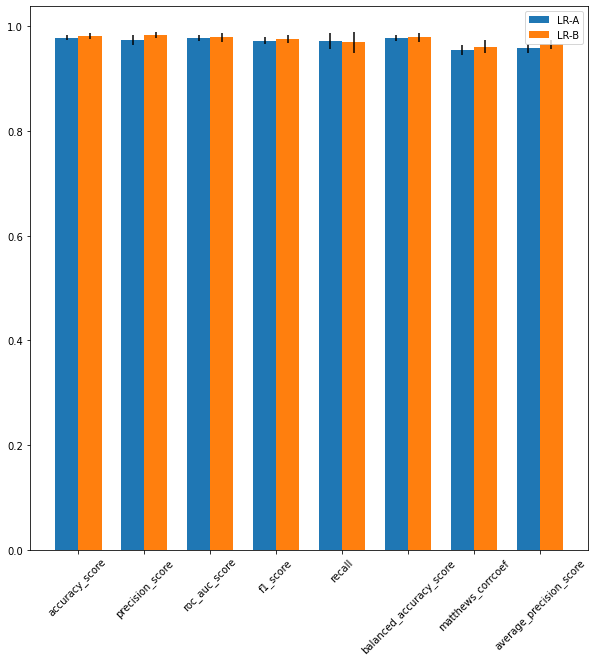

In [ ]:
# Calculate Confidence Intervals
tk = 2.776 # (see https://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf)
confint_A = {}
confint_B = {}
for k in crossval_scores_A.keys():
    
    confint_A[k] = [
        results_crossval_A_mean[k+'_mean']-tk*results_crossval_A_std[k+'_std']/np.sqrt(n_outer),
        results_crossval_A_mean[k+'_mean']+tk*results_crossval_A_std[k+'_std']/np.sqrt(n_outer)
    ]
    
    confint_B[k] = [
        results_crossval_B_mean[k+'_mean']-tk*results_crossval_B_std[k+'_std']/np.sqrt(n_outer),
        results_crossval_B_mean[k+'_mean']+tk*results_crossval_B_std[k+'_std']/np.sqrt(n_outer)

    ]


labels_metrics = [x for x in confint_A.keys() if 'time' not in x]

plt.rc('font', size=10)

fig, ax = plt.subplots(figsize=(10,10))
ax.bar([x-width/2 for x in np.arange(len(labels_metrics))], 
       [results_crossval_A_mean[x] for x in results_crossval_A_mean.keys() if ('mean' in x) and ('time') not in x], 
       yerr=[tk*results_crossval_A_std[x] for x in results_crossval_A_std.keys() if 'time' not in x]/np.sqrt(n_outer),
       width=0.35, label='LR-A')
ax.bar([x+width/2 for x in np.arange(len(labels_metrics))], 
       [results_crossval_B_mean[x] for x in results_crossval_B_mean.keys() if ('mean' in x) and ('time') not in x], 
       yerr=[tk*results_crossval_B_std[x] for x in results_crossval_B_std.keys() if 'time' not in x]/np.sqrt(n_outer),
       width=0.35, label='LR-B')

plt.legend()
ax.set_xticks(np.arange(len(labels_metrics)))
ax.set_xticklabels([x.split('test_')[1] for x in labels_metrics], rotation=45)

plt.show()

In [ ]:
results_crossval_B_mean

{'fit_time_mean': 2.7108708381652833,
 'fit_time_std': 0.316531806838699,
 'score_time_mean': 0.04216179847717285,
 'score_time_std': 0.018289925029777863,
 'test_accuracy_score_mean': 0.9812867754871641,
 'test_accuracy_score_std': 0.004950817264067758,
 'test_average_precision_score_mean': 0.9656113139435822,
 'test_average_precision_score_std': 0.0065153585227348005,
 'test_balanced_accuracy_score_mean': 0.9792722264180014,
 'test_balanced_accuracy_score_std': 0.006735762022555501,
 'test_f1_score_mean': 0.9763117035380399,
 'test_f1_score_std': 0.006503887364448791,
 'test_matthews_corrcoef_mean': 0.9610486694735829,
 'test_matthews_corrcoef_std': 0.010299721418280174,
 'test_precision_score_mean': 0.9836079992043452,
 'test_precision_score_std': 0.004360459152147822,
 'test_recall_mean': 0.9693145623368757,
 'test_recall_std': 0.015810955776757545,
 'test_roc_auc_score_mean': 0.9792722264180014,
 'test_roc_auc_score_std': 0.006735762022555494}

In [ ]:
pd.DataFrame(confint_A)

,fit_time,score_time,test_accuracy_score,test_precision_score,test_roc_auc_score,test_f1_score,test_recall,test_balanced_accuracy_score,test_matthews_corrcoef,test_average_precision_score
0,0.525646,0.012996,0.973676,0.963876,0.971236,0.966739,0.956437,0.971236,0.945133,0.949476
1,0.867538,0.049923,0.983247,0.984352,0.983502,0.979162,0.987503,0.983502,0.965232,0.966378


In [ ]:
pd.DataFrame(confint_B)

,fit_time,score_time,test_accuracy_score,test_precision_score,test_roc_auc_score,test_f1_score,test_recall,test_balanced_accuracy_score,test_matthews_corrcoef,test_average_precision_score
0,2.317908,0.019455,0.975141,0.978195,0.970910,0.968237,0.949686,0.970910,0.948262,0.957523
1,3.103834,0.064868,0.987433,0.989021,0.987634,0.984386,0.988943,0.987634,0.973835,0.973700


In [ ]:
# Train the best classifier on the entire dataset
clfAbest = clfA.best_estimator_
#clfAbest.coef_
clfBbest = clfB.best_estimator_

### Coefficients of the Logistic Regression (A approach)

In [ ]:

pd.DataFrame({'feature':col_A, 'beta':clfAbest.coef_[0]})


,feature,beta
0,nPVS,2.764135
1,nPS,3.783494
2,nPM,3.120089
3,nPP,1.774736
4,nBA,-2.107463
5,nBS,-1.208525
6,nBP,-1.621706


In [ ]:
pd.DataFrame({'feature':col_A, 'beta':clfAbest.coef_[0]})

,feature,beta
0,nPVS,3.243731
1,nPS,8.417687
2,nPM,9.414001
3,nPP,5.222191
4,nBA,-2.287708
5,nBS,-1.252151
6,nBP,-6.100037


### Coefficients of the Logistic Regression (B approach)

In [ ]:
pd.set_option('display.max_rows', 60)
pd.DataFrame({'feature':col_B, 'beta':clfBbest.coef_[0]})

,feature,beta
0,nPVS,2.586992
1,nPS,8.376426
2,nPM,9.579477
3,nPP,3.558662
4,nBA,-1.043326
5,nBS,-1.117472
6,nBP,-4.596606
7,stop_gained,2.629863
8,stop_lost,0.000000
9,frameshift_variant,1.940120


In [ ]:
pd.set_option('display.max_rows', 60)
pd.DataFrame({'feature':col_B, 'beta':clfBbest.coef_[0]})

,feature,beta
0,nPVS,2.460423
1,nPS,8.637155
2,nPM,9.583261
3,nPP,3.435255
4,nBA,-0.226390
5,nBS,-1.167272
6,nBP,-4.832840
7,stop_gained,1.886712
8,stop_lost,-0.729822
9,frameshift_variant,0.489204


In [ ]:
cv_cal = 2 #2

clfAbestcal = CalibratedClassifierCV(clfA.best_estimator_, cv=cv_cal, method="sigmoid")
clfAbest.fit(training_df[col_A], y_train_num)

clfBbestcal = CalibratedClassifierCV(clfB.best_estimator_, cv=cv_cal, method="sigmoid")
clfBbest.fit(training_df[col_B], y_train_num)


# ### Test set Analysis
# Now we evaluate the performance on the test set. Moreover, the test set is exploited to 
# tune the classification threshold

LogisticRegression(C=0.7, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
clfAbestcal.fit(training_df[col_A], y_train_num)
clfBbestcal.fit(training_df[col_B], y_train_num)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=0.7,
                                                         class_weight=None,
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=100,
                                                         multi_class='warn',
                                                         n_jobs=None,
                                                         penalty='l1',
                                                         random_state=1,
                                                         solver='liblinear',
                                                         tol=0.0001, verbose=0,
                                             

In [ ]:
tuning_df_notnorm = tuning_df.copy()
tuning_df_dataset_norm = scaler.transform(tuning_df[col_A+col_B])
tuning_df[col_A+col_B] = tuning_df_dataset_norm

In [ ]:
# First column is the predicted probability that the variant is Benign (1-P(Pathogenic|X))
y_predproba_test_sA = clfAbest.predict_proba(tuning_df[col_A])
y_pred_test_sA = clfAbest.predict(tuning_df[col_A])

y_predproba_test_sB = clfBbest.predict_proba(tuning_df[col_B])
y_pred_test_sB = clfBbest.predict(tuning_df[col_B])



In [ ]:
# calibration
print(brier_score_loss(y_tuning_num, y_predproba_test_sA[:,1]))
print(brier_score_loss(y_tuning_num, clfAbestcal.predict_proba(tuning_df[col_A])[:,1]))
print(brier_score_loss(y_tuning_num, y_predproba_test_sB[:,1]))
print(brier_score_loss(y_tuning_num, clfBbestcal.predict_proba(tuning_df[col_B])[:,1]))

0.015523935301548884
0.015631937099445655
0.012710234872509364
0.013221409506654297


As we can see, the brier scores of the calibrated and non-calibrated results are very low. Therefore, we retain uncalibrated models.

### Setting the best threshold for classification on the Tuning dataset

In [ ]:
beta = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,
        0.7, 0.75, 0.8, 0.85, 0.9, 1, 1.5]
beta_sel = 0.35

prec_A, recall_A, threshold_A = precision_recall_curve(y_tuning_num, y_predproba_test_sA[:,1])
selected_thr_A = dict.fromkeys(beta)
for b in beta:
    beta_q = pow(b, 2)
    Fbeta_A = (1 + beta_q) * prec_A * recall_A / (beta_q * prec_A + recall_A)
    selected_thr_A[b] = threshold_A[np.where(Fbeta_A == np.max(Fbeta_A))[0]][0]

In [ ]:
selected_thr_A

{0.1: 0.9731813822905613,
 0.15: 0.887600773706037,
 0.2: 0.887600773706037,
 0.25: 0.8642144284882632,
 0.3: 0.8642144284882632,
 0.35: 0.8513227228310183,
 0.4: 0.8513227228310183,
 0.45: 0.7455705576025314,
 0.5: 0.7455705576025314,
 0.55: 0.7455705576025314,
 0.6: 0.5860702119055988,
 0.65: 0.5860702119055988,
 0.7: 0.5547802522564721,
 0.75: 0.5547802522564721,
 0.8: 0.5547802522564721,
 0.85: 0.5547802522564721,
 0.9: 0.44172556460196455,
 1: 0.28814555339180803,
 1.5: 0.28814555339180803}

In [ ]:

prec_B, recall_B, threshold_B = precision_recall_curve(y_tuning_num, y_predproba_test_sB[:,1])
selected_thr_B = dict.fromkeys(beta)
for b in beta:
    beta_q = pow(b, 2)
    Fbeta_B = (1 + beta_q) * prec_B * recall_B / (beta_q * prec_B + recall_B)
    selected_thr_B[b] = threshold_B[np.where(Fbeta_B == np.max(Fbeta_B))[0]][0]
selected_thr_B

{0.1: 0.9446784671041649,
 0.15: 0.9446784671041649,
 0.2: 0.9446784671041649,
 0.25: 0.9446784671041649,
 0.3: 0.9446784671041649,
 0.35: 0.8366657177100298,
 0.4: 0.6948569709360064,
 0.45: 0.6407247492766271,
 0.5: 0.6407247492766271,
 0.55: 0.6407247492766271,
 0.6: 0.6407247492766271,
 0.65: 0.6407247492766271,
 0.7: 0.6106280272562613,
 0.75: 0.6106280272562613,
 0.8: 0.6106280272562613,
 0.85: 0.6106280272562613,
 0.9: 0.4344905881409308,
 1: 0.4344905881409308,
 1.5: 0.22479905154429952}

In [ ]:
# Pathogenicity Score
prec_ps, recall_ps, threshold_ps = precision_recall_curve(y_tuning_num, calc_patho_score(tuning_df_notnorm))
selected_thr_ps = dict.fromkeys(beta)
for b in beta:
    beta_q = pow(b, 2)
    Fbeta_B = (1 + beta_q) * prec_ps * recall_ps / (beta_q * prec_ps + recall_ps)
    selected_thr_ps[b] = threshold_ps[np.where(Fbeta_B == np.max(Fbeta_B))[0]][0]

In [ ]:
selected_thr_ps

{0.1: 5.0,
 0.15: 5.0,
 0.2: 5.0,
 0.25: 4.0,
 0.3: 4.0,
 0.35: 4.0,
 0.4: 3.0,
 0.45: 3.0,
 0.5: 3.0,
 0.55: 3.0,
 0.6: 3.0,
 0.65: 2.5,
 0.7: 2.5,
 0.75: 2.0,
 0.8: 2.0,
 0.85: 2.0,
 0.9: 2.0,
 1: 2.0,
 1.5: 2.0}

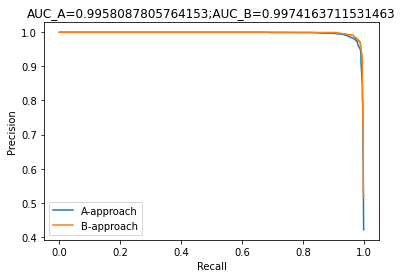

In [ ]:
ave_prec_sA = (average_precision_score(y_tuning_num, y_predproba_test_sA[:,1]))
ave_prec_sB = (average_precision_score(y_tuning_num, y_predproba_test_sB[:,1]))


plt.clf()
plt.plot(recall_A, prec_A, label='A-approach')
plt.plot(recall_B, prec_B, label='B-approach')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(label='AUC_A='+str(ave_prec_sA)+';AUC_B='+str(ave_prec_sB))
plt.legend(loc="lower left")
plt.show()

Results on 10% of Clinvitae 2017 (Validation)

In [ ]:
test_df_notnorm = test_df.copy()
test_norm_dataset = scaler.transform(test_df[col_A+col_B])
test_df[col_A+col_B] = test_norm_dataset

y_predproba_val_sA = clfAbest.predict_proba(test_df[col_A])
res_lrA_clin2017val = pd.DataFrame.from_dict(get_metrics_fromscores(y_test_num, 
                                              y_predproba_val_sA[:,1], 
                                              selected_thr_A[beta_sel], scoring),
                      orient='index', columns=['LR-A'])

In [ ]:
test_df[col_B].describe()

,nPVS,nPS,nPM,nPP,nBA,nBS,nBP,stop_gained,stop_lost,frameshift_variant,start_lost,exon_loss,exon_loss_variant,splice_acceptor_variant,splice_donor_variant,disruptive_inframe_insertion,disruptive_inframe_deletion,inframe_insertion,inframe_deletion,missense_variant,initiator_codon_variant,splice_region_variant,start_retained,non_canonical_start_codon,stop_retained_variant,synonymous_variant,exon_variant,transcript,intron_variant,5_prime_UTR_premature_start_codon_gain_variant,3_prime_UTR_truncation,5_prime_UTR_truncation,5_prime_UTR_variant,3_prime_UTR_variant,intragenic_variant,intergenic_region,upstream_gene_variant,downstream_gene_variant,RepeatMasker,ExAC_AF,ExAC_isTarget,gnomAD_WGS__gnomAD_WES_AF_ALL,gnomAD_WGS__gnomAD_WES_Hom_ALL,DBSNP_1TGP_ALT_freq,ESP6500SIv2_All_freq,DANN_score,dbscSNV_AB_score,dbscSNV_RF_score,PaPI_score,PolyPhen-2_score,SIFT_score,PseeAC-RF_score,HotSpot
count,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.0,1415.0,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.0,1415.000000,1415.0,1415.0,1415.000000,1415.000000,1415.0,1415.0,1415.000000,1415.000000,1415.0,1415.0,1415.000000,1415.000000,1415.000000,1415.0,1415.0,1415.0,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000
mean,0.189399,0.126855,0.174323,0.283157,0.195760,0.053710,0.183039,0.067809,0.000353,0.100942,0.001767,0.0,0.0,0.013428,0.015548,0.003062,0.009187,0.001767,0.002827,0.323380,0.0,0.064782,0.0,0.0,0.001178,0.181001,0.0,0.0,0.236337,0.003581,0.0,0.0,0.018810,0.012250,0.044664,0.0,0.0,0.0,0.029682,0.071353,0.995053,0.070069,0.036452,0.072158,0.068965,0.680211,0.049953,0.048116,0.715499,0.481801,0.418682,0.737665,0.115194
std,0.391964,0.217644,0.242927,0.307706,0.396925,0.225525,0.246393,0.238682,0.013292,0.283870,0.033416,0.0,0.0,0.110435,0.116399,0.053834,0.087720,0.039851,0.049671,0.435009,0.0,0.233619,0.0,0.0,0.031940,0.366802,0.0,0.0,0.373139,0.045440,0.0,0.0,0.106896,0.083669,0.140637,0.0,0.0,0.0,0.169768,0.187596,0.070186,0.186116,0.136006,0.191629,0.170839,0.366952,0.215651,0.198971,0.243350,0.321474,0.254267,0.228276,0.319369
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.484708,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.000000
50%,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000701,1.000000,0.000701,0.000000,0.000998,0.000972,0.826695,0.000000,0.000000,0.516000,0.500000,0.500000,0.713000,0.000000
75%,0.000000,0.500000,0.333333,0.333333,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.500000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.009800,1.000000,0.008944,0.000285,0.010780,0.012680,0.994129,0.000000,0.000000,0.996000,0.530000,0.500000,0.987750,0.000000

In [ ]:

y_predproba_val_sB = clfBbest.predict_proba(test_df[col_B])
get_metrics_fromscores(y_test_num, y_predproba_val_sB[:,1], selected_thr_B[beta_sel], scoring)

res_lrB_clin2017val = pd.DataFrame.from_dict(get_metrics_fromscores(y_test_num, 
                                              y_predproba_val_sB[:,1], 
                                              selected_thr_B[beta_sel], scoring),
                      orient='index', columns=['LR-B'])

res_PS_clin2017val = pd.DataFrame.from_dict(get_metrics_fromscores(y_test_num, 
                                                                   calc_patho_score(test_df_notnorm),
                                                                   selected_thr_ps[beta_sel], scoring),
                      orient='index', columns=['PS'])

pd.concat((res_lrA_clin2017val, res_lrB_clin2017val, res_PS_clin2017val), axis=1)

,LR-A,LR-B,PS
accuracy_score,0.975265,0.978092,0.959717
precision_score,0.988950,0.992634,0.994175
roc_auc_score,0.970848,0.973793,0.950530
f1_score,0.968440,0.972047,0.947271
recall,0.948763,0.952297,0.904594
balanced_accuracy_score,0.970848,0.973793,0.950530
matthews_corrcoef,0.948669,0.954602,0.917468
average_precision_score,0.958774,0.964363,0.937487


## Validation



### Clinvitae 2019 Dataset

Validate results on Clinvitae 2019 Dataset

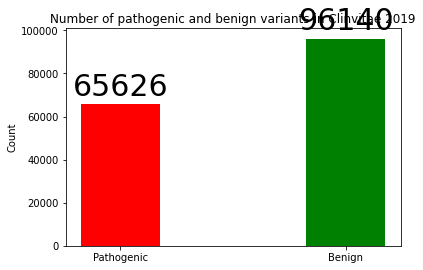

In [ ]:
df_clin_2019 = pd.read_csv(ROOT_PATH + 'pubblication_data/clinvitae2019/Clinvitae_2019_dataset.tsv',
                     sep='\t')
c2019_only = df_clin_2019[[x for x in df_clin_2019.columns if x != 'FINAL_CLASSIFICATION']]
y_c2019_only = df_clin_2019['FINAL_CLASSIFICATION']

# Proportions of Pathogenic and Benign in Clinvitae 2019
bars = ('Pathogenic', 'Benign')
y_pos = np.arange(len(bars))


fig, ax = plt.subplots()
rect = ax.bar(y_pos, list(Counter(y_c2019_only).values())[::-1],
        width=0.35,
        color=['r', 'g'])
ax.set_ylabel('Count')
ax.set_title('Number of pathogenic and benign variants in Clinvitae 2019')
plt.xticks(y_pos, bars)
autolabel(rect)
plt.show()

In [ ]:
# Bayesian Score
X=2
prior_p = 0.1
odd_pvs = 350
expo = c2019_only['nPP'] / np.power(X,3) + c2019_only['nPM']/ np.power(X, 2) + c2019_only['nPS']/ X + c2019_only['nPVS']
odds = np.power(odd_pvs, expo)
postp = odds*prior_p/((odds-1)*prior_p+1)
ypred_bayes_c2019 = [int(x) for x in postp >= 0.9]#selected_thr_bayes[0.4]]#0.9]

c2019_only_norm = c2019_only.copy()
c2019_only_norm[col_A+col_B] = scaler.transform(c2019_only[col_A+col_B])
ypred_proba_c2019_A = clfAbest.predict_proba(c2019_only_norm[col_A])
ypred_proba_c2019_B = clfBbest.predict_proba(c2019_only_norm[col_B])

ypred_c2019_A = [int(x) for x in ypred_proba_c2019_A[:,1] >= selected_thr_A[beta_sel]]#0.9]#selected_thr_A[0.4]]
ypred_c2019_B = [int(x) for x in ypred_proba_c2019_B[:,1] >= selected_thr_B[beta_sel]]#0.9]#selected_thr_B[0.4]]

# Prediction with eVai
threshold_evai = 3
ypred_evai_c2019 = [int(x) for x in calc_patho_score(c2019_only) > threshold_evai]


evai_scores_c2019 = get_metrics_frompred(y_c2019_only, ypred_evai_c2019, scoring)
bayes_scores_c2019 = get_metrics_frompred(y_c2019_only, ypred_bayes_c2019, scoring)
lrA_scores_c2019 = get_metrics_frompred(y_c2019_only, ypred_c2019_A, scoring)
lrB_scores_c2019 = get_metrics_frompred(y_c2019_only, ypred_c2019_B, scoring)


In [ ]:
res_clin2019 = pd.concat((pd.DataFrame.from_dict(bayes_scores_c2019.items()),
                          pd.DataFrame.from_dict(evai_scores_c2019.values()),
                          pd.DataFrame.from_dict(lrA_scores_c2019.values()),
                          pd.DataFrame.from_dict(lrB_scores_c2019.values())
                          ),
                         axis=1)
res_clin2019.columns = ['Metric', 'Bayes', 'PS', 'LogA', 'LogB']

In [ ]:
res_clin2019

,Metric,Bayes,PS,LogA,LogB
0,accuracy_score,0.908287,0.955986,0.971793,0.970204
1,precision_score,0.997922,0.987047,0.990096,0.994342
2,roc_auc_score,0.887222,0.947635,0.966727,0.964118
3,f1_score,0.872792,0.943352,0.964330,0.962085
4,recall,0.775546,0.903361,0.939871,0.931856
5,balanced_accuracy_score,0.887222,0.947635,0.966727,0.964118
6,matthews_corrcoef,0.818440,0.909860,0.941901,0.938926
7,average_precision_score,0.864992,0.930865,0.954956,0.954228


Let's see the differences between classification on ClinVar Variants

In [ ]:
c2019_anno = pd.read_csv(ROOT_PATH + 'pubblication_data/clinvitae2019/2019_11_Clinvitae.ACMG.tsv',
                         sep='\t')

c2019_anno = c2019_anno.rename(columns={'#CHROM':'CHROMOSOME'})
c2019_anno['CHROMOSOME'] = 'chr'+c2019_anno['CHROMOSOME'].astype(str)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Variant in Clinvitae up to 2019 and in Clinvar
clin2019_in_clinvar = pd.read_csv(ROOT_PATH+'pubblication_data/clinvitae2019/clinvitae2019_in_clinvar.tsv',
                                  sep='\t')


# Variant in Clinvitae up to 2019 and in Clinvar
clin2019_not_in_clinvar = pd.read_csv(ROOT_PATH+'pubblication_data/clinvitae2019/clinvitae2019_not_in_clinvar.tsv',
                                  sep='\t')

clin2019_in_clinvar['CHR'] = ['chr'+x for x in clin2019_in_clinvar['CHR']]
clin2019_not_in_clinvar['CHR'] = ['chr'+x for x in clin2019_not_in_clinvar['CHR']]

clin2019_in_clinvar = clin2019_in_clinvar.rename(columns={'CHR':'CHROMOSOME'})
clin2019_not_in_clinvar = clin2019_not_in_clinvar.rename(columns={'CHR':'CHROMOSOME'})

c2019_only_prediction = c2019_only.copy()
c2019_only_prediction['PRED_A'] = ypred_c2019_A
c2019_only_prediction['PRED_B'] = ypred_c2019_B
str2int = {'Pathogenic':1, 'Benign':0}
c2019_only_prediction['TRUE_CLASS_NUM'] = [str2int[x] for x in c2019_only_prediction['TRUE_CLASS']]

c2019_only_prediction_clinvar = pd.merge(c2019_only_prediction, clin2019_in_clinvar[kcol], left_on=kcol,
                                         right_on=kcol).drop_duplicates()


c2019_only_prediction_not_clinvar = pd.merge(c2019_only_prediction, clin2019_not_in_clinvar[kcol], left_on=kcol,
                                         right_on=kcol).drop_duplicates()
                                         


In [ ]:
str2int = {'Pathogenic':1, 'Benign':0}

tp_clin2019_clinvar_lrA, fp_clin2019_clinvar_lrA, fn_clin2019_clinvar_lrA, tn_clin2019_clinvar_lrA = confusion_matrix(c2019_only_prediction_clinvar['TRUE_CLASS_NUM'],
                                                                                                                      c2019_only_prediction_clinvar['PRED_A']).ravel()
tp_clin2019_clinvar_lrB, fp_clin2019_clinvar_lrB, fn_clin2019_clinvar_lrB, tn_clin2019_clinvar_lrB = confusion_matrix(c2019_only_prediction_clinvar['TRUE_CLASS_NUM'],
                                                                                                                      c2019_only_prediction_clinvar['PRED_B']).ravel()

tp_clin2019_noclinvar_lrA, fp_clin2019_noclinvar_lrA, fn_clin2019_noclinvar_lrA, tn_clin2019_noclinvar_lrA = confusion_matrix(c2019_only_prediction_not_clinvar['TRUE_CLASS_NUM'],
                                                                                                                      c2019_only_prediction_not_clinvar['PRED_A']).ravel()
tp_clin2019_noclinvar_lrB, fp_clin2019_noclinvar_lrB, fn_clin2019_noclinvar_lrB, tn_clin2019_noclinvar_lrB = confusion_matrix(c2019_only_prediction_not_clinvar['TRUE_CLASS_NUM'],
                                                                                                                      c2019_only_prediction_not_clinvar['PRED_B']).ravel()


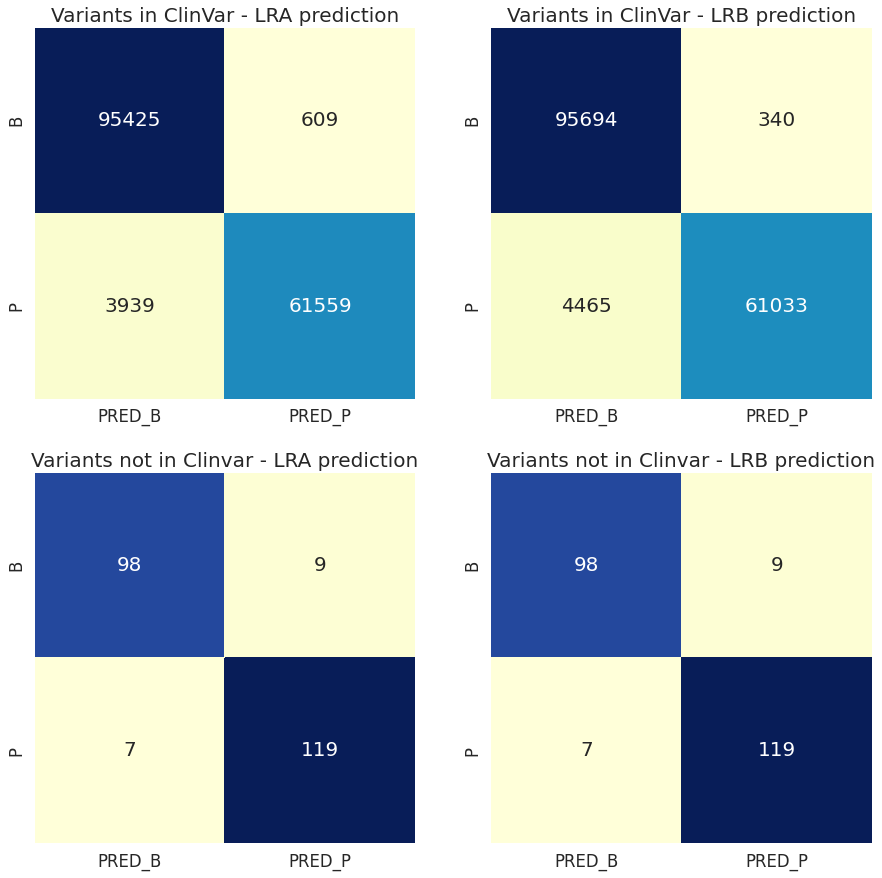

In [ ]:
import seaborn as sn


sn.set(font_scale=1.5) # for label size
fig, ax = plt.subplots(2,2, figsize=(15, 15))

sn.heatmap(ax=ax[0,0], data=pd.DataFrame(confusion_matrix(c2019_only_prediction_clinvar['TRUE_CLASS_NUM'],
                                                          c2019_only_prediction_clinvar['PRED_A']), 
                                  index=['B', 'P'], columns=['PRED_B', 'PRED_P']), cbar=False, annot=True, cmap="YlGnBu", fmt="d", annot_kws={"size": 20}) # font size
ax[0,0].set_title('Variants in ClinVar - LRA prediction', fontsize=20)

sn.heatmap(ax=ax[0,1], data=pd.DataFrame(confusion_matrix(c2019_only_prediction_clinvar['TRUE_CLASS_NUM'],
                                                          c2019_only_prediction_clinvar['PRED_B']), 
                                  index=['B', 'P'], columns=['PRED_B', 'PRED_P']), cbar=False, annot=True, cmap="YlGnBu", fmt="d", annot_kws={"size": 20}) # font size
ax[0,1].set_title('Variants in ClinVar - LRB prediction', fontsize=20)

sn.heatmap(ax=ax[1,0], data=pd.DataFrame(confusion_matrix(c2019_only_prediction_not_clinvar['TRUE_CLASS_NUM'],
                                                          c2019_only_prediction_not_clinvar['PRED_A']), 
                                  index=['B', 'P'], columns=['PRED_B', 'PRED_P']), cbar=False, annot=True, cmap="YlGnBu", fmt="d", annot_kws={"size": 20}) # font size
ax[1,0].set_title('Variants not in Clinvar - LRA prediction', fontsize=20)

sn.heatmap(ax=ax[1,1], data=pd.DataFrame(confusion_matrix(c2019_only_prediction_not_clinvar['TRUE_CLASS_NUM'],
                                                          c2019_only_prediction_not_clinvar['PRED_B']), 
                                  index=['B', 'P'], columns=['PRED_B', 'PRED_P']), cbar=False, annot=True, cmap="YlGnBu", fmt="d", annot_kws={"size": 20}) # font size
ax[1,1].set_title('Variants not in Clinvar - LRB prediction', fontsize=20)

#plt.savefig(ROOT_PATH + 'confmat_PP5.png', dpi=300)
fig.show()

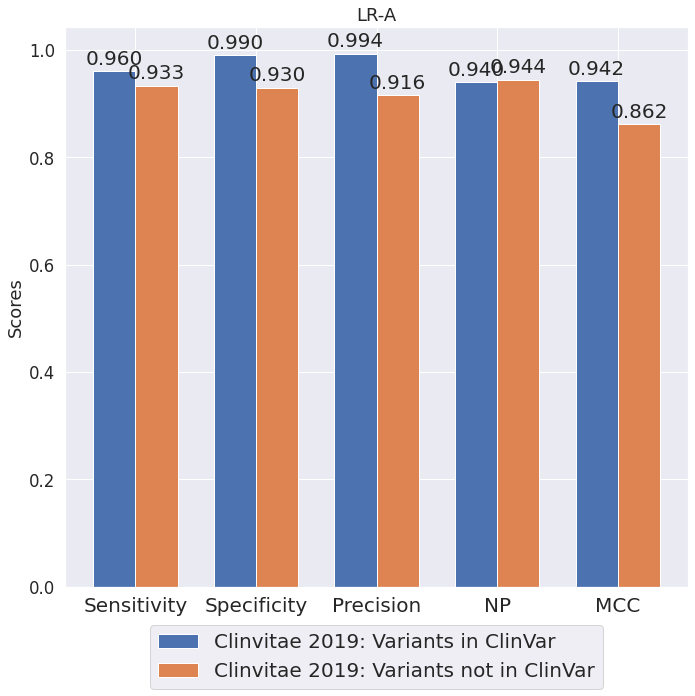

In [ ]:
labels = ['Sensitivity', 'Specificity', 'Precision', 'NP', 'MCC']

clinvar_true_A = [tp_clin2019_clinvar_lrA/(tp_clin2019_clinvar_lrA+fn_clin2019_clinvar_lrA), 
            tn_clin2019_clinvar_lrA/(tn_clin2019_clinvar_lrA+fp_clin2019_clinvar_lrA), 
            tp_clin2019_clinvar_lrA/(tp_clin2019_clinvar_lrA+fp_clin2019_clinvar_lrA),
            tn_clin2019_clinvar_lrA/(tn_clin2019_clinvar_lrA+fn_clin2019_clinvar_lrA),
            matthews_corrcoef(c2019_only_prediction_clinvar['TRUE_CLASS_NUM'], c2019_only_prediction_clinvar['PRED_A'])]

clinvar_false_A = [tp_clin2019_noclinvar_lrA/(tp_clin2019_noclinvar_lrA+fn_clin2019_noclinvar_lrA), 
            tn_clin2019_noclinvar_lrA/(tn_clin2019_noclinvar_lrA+fp_clin2019_noclinvar_lrA), 
            tp_clin2019_noclinvar_lrA/(tp_clin2019_noclinvar_lrA+fp_clin2019_noclinvar_lrA),
            tn_clin2019_noclinvar_lrA/(tn_clin2019_noclinvar_lrA+fn_clin2019_noclinvar_lrA),
            matthews_corrcoef(c2019_only_prediction_not_clinvar['TRUE_CLASS_NUM'], c2019_only_prediction_not_clinvar['PRED_A'])]



x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(x - width/2, clinvar_true_A, width, label='Clinvitae 2019: Variants in ClinVar')
rects2 = ax.bar(x + width/2, clinvar_false_A, width, label='Clinvitae 2019: Variants not in ClinVar')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('LR-A')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=20)
ax.legend(fontsize=20,loc='upper center',bbox_to_anchor=(0.5, -0.05))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=20)


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig(ROOT_PATH + 'performance_LRA_ClinVar_vs_NoClinVar.png', dpi=300)
plt.show()


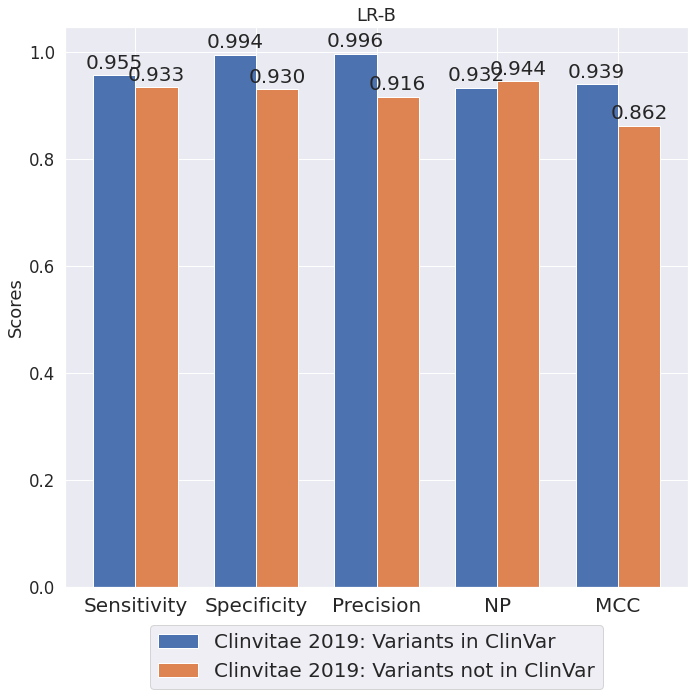

In [ ]:
labels = ['Sensitivity', 'Specificity', 'Precision', 'NP', 'MCC']

clinvar_true_A = [tp_clin2019_clinvar_lrB/(tp_clin2019_clinvar_lrB+fn_clin2019_clinvar_lrB), 
            tn_clin2019_clinvar_lrB/(tn_clin2019_clinvar_lrB+fp_clin2019_clinvar_lrB), 
            tp_clin2019_clinvar_lrB/(tp_clin2019_clinvar_lrB+fp_clin2019_clinvar_lrB),
            tn_clin2019_clinvar_lrB/(tn_clin2019_clinvar_lrB+fn_clin2019_clinvar_lrB),
            matthews_corrcoef(c2019_only_prediction_clinvar['TRUE_CLASS_NUM'], c2019_only_prediction_clinvar['PRED_B'])]

clinvar_false_A = [tp_clin2019_noclinvar_lrB/(tp_clin2019_noclinvar_lrB+fn_clin2019_noclinvar_lrB), 
            tn_clin2019_noclinvar_lrB/(tn_clin2019_noclinvar_lrB+fp_clin2019_noclinvar_lrB), 
            tp_clin2019_noclinvar_lrB/(tp_clin2019_noclinvar_lrB+fp_clin2019_noclinvar_lrB),
            tn_clin2019_noclinvar_lrB/(tn_clin2019_noclinvar_lrB+fn_clin2019_noclinvar_lrB),
            matthews_corrcoef(c2019_only_prediction_not_clinvar['TRUE_CLASS_NUM'], c2019_only_prediction_not_clinvar['PRED_B'])]



x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(x - width/2, clinvar_true_A, width, label='Clinvitae 2019: Variants in ClinVar')
rects2 = ax.bar(x + width/2, clinvar_false_A, width, label='Clinvitae 2019: Variants not in ClinVar')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('LR-B')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=20)
ax.legend(fontsize=20,loc='upper center',bbox_to_anchor=(0.5, -0.05))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=20)


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig(ROOT_PATH + 'performance_lrB_ClinVar_vs_NoClinVar.png', dpi=300)
plt.show()



#### Perfomance on Variants interpreted as VUS by the ACMG/AMP
Performance on variants interpreted as **VUS** by eVai (according to the ACMG/AMP guidelines)

In [ ]:
# Input: df with variants and their levels of evidence (as in the datasets)
def get_acmg_classification(df):
  # For each variant, determine the ACMG/AMP classification
  is_p = df.apply(lambda x: pathogenic_rule(x), axis=1)
  is_lp = df.apply(lambda x: likelypatho_rule(x), axis=1)
  is_b = df.apply(lambda x: benign_rule(x), axis=1)
  is_lb = df.apply(lambda x: likelybenign_rule(x), axis=1)

  # Find VUS, i.e.:
  # 1) Variants with conflicting interpretation
  is_conflict = ((is_p | is_lp) & (is_b | is_lb))
  acmg_class = pd.Series(["VUS"]*df.shape[0])
  acmg_class[is_lb] = "LB"
  acmg_class[is_b] = "B"
  acmg_class[is_lp] = "LP"
  acmg_class[is_p] = "P"
  acmg_class[is_conflict] = "VUS conflict"

  return acmg_class

In [ ]:
acmg_class_c2019 = get_acmg_classification(c2019_only_prediction)

Classification of Clinvitae Validation according to the ACMG/AMP guidelines

In [ ]:
Counter(acmg_class_c2019)

Counter({'B': 15571,
         'LB': 64126,
         'LP': 18150,
         'P': 34914,
         'VUS': 28399,
         'VUS conflict': 606})

Therefore, the number of VUS variants in the Clinvitae 2019 dataset is

In [ ]:
Counter(acmg_class_c2019)['VUS'] + Counter(acmg_class_c2019)['VUS conflict']

29005

In [ ]:
# Percentage of VUS
print('Percentage of VUS in Clin2019', (Counter(acmg_class_c2019)['VUS'] + Counter(acmg_class_c2019)['VUS conflict']) / len(acmg_class_c2019))

Percentage of VUS in Clin2019 0.17930220194602078


In [ ]:
# Find VUS variants
iVUS_c2019 = [i for i in range(len(acmg_class_c2019)) if 'VUS' in acmg_class_c2019[i]]

In [ ]:
# Number of P variants interpreted as VUS
print('% of Pathogenic variants interpreted as VUS', 
      len([i for i in range(len(iVUS_c2019)) if y_c2019_only[iVUS_c2019[i]] == 1])/len(iVUS_c2019))

print('% of Benign variants interpreted as VUS', 
      len([i for i in range(len(iVUS_c2019)) if y_c2019_only[iVUS_c2019[i]] == 0])/len(iVUS_c2019))

% of Pathogenic variants interpreted as VUS 0.4251335976555766
% of Benign variants interpreted as VUS 0.5748664023444233


In [ ]:

evai_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019], 
                                         [x for i,x in enumerate(ypred_evai_c2019) if i in iVUS_c2019], 
                                         scoring)
bayes_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019],
                                          [x for i,x in enumerate(ypred_bayes_c2019) if i in iVUS_c2019], 
                                          scoring)
lrA_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019], 
                                        [x for i,x in enumerate(ypred_c2019_A) if i in iVUS_c2019], 
                                        scoring)
lrB_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019], 
                                        [x for i,x in enumerate(ypred_c2019_B) if i in iVUS_c2019], 
                                        scoring)




In [ ]:
res_c2019_onvus = pd.concat((
                          pd.DataFrame.from_dict(evai_scores_onvus.values()),
                          pd.DataFrame.from_dict(bayes_scores_onvus.values()),
                          pd.DataFrame.from_dict(lrA_scores_onvus.values()),
                          pd.DataFrame.from_dict(lrB_scores_onvus.values()),
                          ),
                         axis=1)

res_c2019_onvus.columns = ['PS','Bayes', 'LogA', 'LogB']
res_c2019_onvus.index = list(evai_scores_onvus.keys())

# Results of PS, Bayes score, LR-A and LR-B on variants interpreted as VUS by the ACMG/AMP guidelines
res_c2019_onvus

,PS,Bayes,LogA,LogB
accuracy_score,0.779314,0.616101,0.863024,0.850715
precision_score,0.943597,0.967919,0.958224,0.970370
roc_auc_score,0.744433,0.548929,0.842926,0.827088
f1_score,0.663371,0.181791,0.814787,0.792187
recall,0.511475,0.100316,0.708702,0.669289
balanced_accuracy_score,0.744433,0.548929,0.842926,0.827088
matthews_corrcoef,0.573896,0.235720,0.730279,0.710394
average_precision_score,0.690315,0.479584,0.802935,0.790054


In [ ]:
# Results on the entire set
res_clin2019


,Metric,Bayes,PS,LogA,LogB
0,accuracy_score,0.908287,0.955986,0.971793,0.970204
1,precision_score,0.997922,0.987047,0.990096,0.994342
2,roc_auc_score,0.887222,0.947635,0.966727,0.964118
3,f1_score,0.872792,0.943352,0.964330,0.962085
4,recall,0.775546,0.903361,0.939871,0.931856
5,balanced_accuracy_score,0.887222,0.947635,0.966727,0.964118
6,matthews_corrcoef,0.818440,0.909860,0.941901,0.938926
7,average_precision_score,0.864992,0.930865,0.954956,0.954228


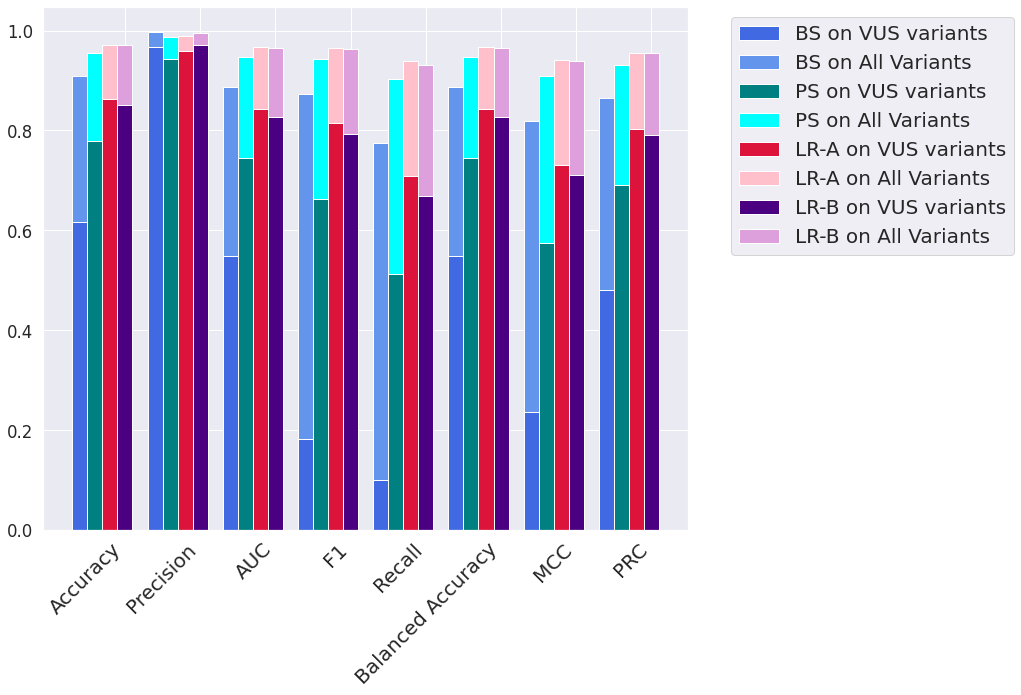

In [ ]:
relevant_metrics = ['accuracy_score', 'precision_score', 'roc_auc_score', 'f1_score', 'recall', 'balanced_accuracy_score',
                    'matthews_corrcoef', 'average_precision_score']

labels = ['Accuracy', 'Precision', 'AUC', 'F1', 'Recall', 'Balanced Accuracy', 'MCC', 'PRC']
width = 0.20
r1 = np.arange(len(labels)) 
r2 = [x + width for x in r1] 
r3 = [x + width for x in r2]
r4 = [x + width for x in r3] 

fig, ax = plt.subplots(figsize=(10,10))
bayes_on_vus = res_c2019_onvus.loc[relevant_metrics]['Bayes'].tolist()
ps_on_vus = res_c2019_onvus.loc[relevant_metrics]['PS'].tolist()
lra_on_vus = res_c2019_onvus.loc[relevant_metrics]['LogA'].tolist()
lrb_on_vus = res_c2019_onvus.loc[relevant_metrics]['LogB'].tolist()
# Make the plot
ax.bar(r1, bayes_on_vus , color='royalblue', width=width, edgecolor='white', label='BS on VUS variants')
ax.bar(r1, [res_clin2019[res_clin2019['Metric']==i]['Bayes'].values[0]- res_c2019_onvus.loc[i, 'Bayes'] for i in relevant_metrics],
       width=width, edgecolor='white',color='cornflowerblue', label='BS on All Variants', bottom=bayes_on_vus)

ax.bar(r2, ps_on_vus,  width=width, edgecolor='white', color='teal', label='PS on VUS variants')
ax.bar(r2, [res_clin2019[res_clin2019['Metric']==i]['PS'].values[0]- res_c2019_onvus.loc[i, 'PS'] for i in relevant_metrics],
       width=width, edgecolor='white',color='aqua', label='PS on All Variants', bottom=ps_on_vus)

ax.bar(r3, lra_on_vus,  width=width, edgecolor='white', color='crimson', label='LR-A on VUS variants')
ax.bar(r3, [res_clin2019[res_clin2019['Metric']==i]['LogA'].values[0]- res_c2019_onvus.loc[i, 'LogA'] for i in relevant_metrics],
       width=width, edgecolor='white',color='pink', label='LR-A on All Variants', bottom=lra_on_vus)

ax.bar(r4, lrb_on_vus,  width=width, edgecolor='white', color='indigo', label='LR-B on VUS variants')
ax.bar(r4, [res_clin2019[res_clin2019['Metric']==i]['LogB'].values[0]- res_c2019_onvus.loc[i, 'LogB'] for i in relevant_metrics],
       width=width, edgecolor='white',color='plum', label='LR-B on All Variants', bottom=lrb_on_vus)

 
# Add xticks on the middle of the group bars
ax.set_xticks(r4)
ax.set_xticklabels(labels, ha="right", rotation=45, fontsize=20)

fig.tight_layout()
# Create legend & Show graphic
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
# Precision-Recall on Clinvitae 2019 (all variants )
pr_A_c2019, rec_A_c2019, thr_A_c2019 = precision_recall_curve(y_c2019_only, ypred_proba_c2019_A[:,1])
pr_B_c2019, rec_B_c2019, thr_B_c2019 = precision_recall_curve(y_c2019_only, ypred_proba_c2019_B[:,1])
pr_Bayes_c2019, rec_Bayes_c2019, thr_Bayes_c2019 = precision_recall_curve(y_c2019_only, postp)
pr_PS_c2019, rec_PS_c2019, thr_PS_c2019 = precision_recall_curve(y_c2019_only, calc_patho_score(c2019_only))

# Precision Recall on Clinvitae 2019 (only VUS variants according to the ACMG)
pr_A_c2019_vus, rec_A_c2019_vus, thr_A_c2019_vus = precision_recall_curve([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019],
                                                                          [x for i,x in enumerate(ypred_proba_c2019_A[:,1]) if i in iVUS_c2019])
pr_B_c2019_vus, rec_B_c2019_vus, thr_B_c2019_vus = precision_recall_curve([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019], 
                                                                         [ x for i,x in enumerate(ypred_proba_c2019_B[:,1]) if i in iVUS_c2019]
                                                                          )
pr_Bayes_c2019_vus, rec_Bayes_c2019_vus, thr_Bayes_c2019_vus = precision_recall_curve([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019],
                                                                                      [x for i,x in enumerate(postp) if i in iVUS_c2019]
                                                                                      )
pr_PS_c2019_vus, rec_PS_c2019_vus, thr_PS_c2019_vus = precision_recall_curve([x for i,x in enumerate(y_c2019_only) if i in iVUS_c2019],
                                                                             [x for i,x in enumerate(calc_patho_score(c2019_only)) if i in iVUS_c2019]
                                                                             )


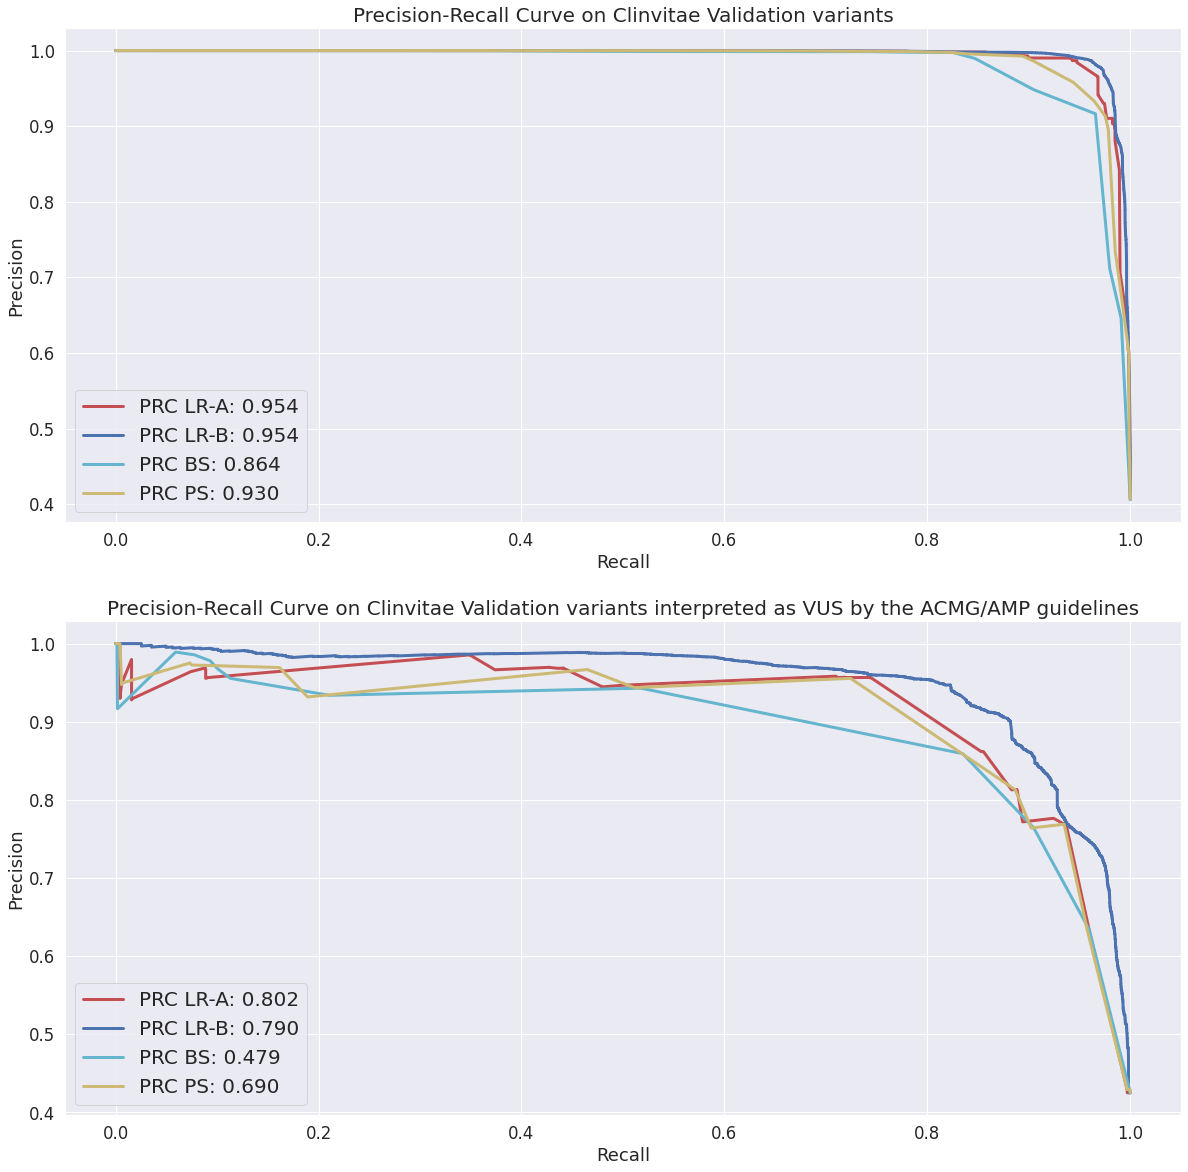

In [ ]:
res_c2019_onvus['Metric'] = res_c2019_onvus.index

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,20))
ax[0].plot(rec_A_c2019, pr_A_c2019, c='r', linewidth=3, 
           label='PRC LR-A: '+str(res_clin2019[res_clin2019['Metric']=='average_precision_score']['LogA'].values[0])[0:5])
ax[0].plot(rec_B_c2019, pr_B_c2019, c='b', linewidth=3, 
           label='PRC LR-B: '+str(res_clin2019[res_clin2019['Metric']=='average_precision_score']['LogB'].values[0])[0:5])


ax[0].plot(rec_Bayes_c2019, pr_Bayes_c2019, c='c', linewidth=3, 
           label='PRC BS: '+str(res_clin2019[res_clin2019['Metric']=='average_precision_score']['Bayes'].values[0])[0:5])

ax[0].plot(rec_PS_c2019, pr_PS_c2019, c='y', linewidth=3, 
           label='PRC PS: '+str(res_clin2019[res_clin2019['Metric']=='average_precision_score']['PS'].values[0])[0:5])


ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision-Recall Curve on Clinvitae Validation variants',
                fontsize=20)
ax[0].legend(fontsize=20)

ax[1].plot(rec_A_c2019_vus, pr_A_c2019_vus, c='r', linewidth=3, 
           label='PRC LR-A: '+str(res_c2019_onvus[res_c2019_onvus['Metric']=='average_precision_score']['LogA'].values[0])[0:5])
ax[1].plot(rec_B_c2019_vus, pr_B_c2019_vus, c='b', linewidth=3, 
           label='PRC LR-B: '+str(res_c2019_onvus[res_c2019_onvus['Metric']=='average_precision_score']['LogB'].values[0])[0:5])


ax[1].plot(rec_Bayes_c2019_vus, pr_Bayes_c2019_vus, c='c', linewidth=3, 
           label='PRC BS: '+str(res_c2019_onvus[res_c2019_onvus['Metric']=='average_precision_score']['Bayes'].values[0])[0:5])

ax[1].plot(rec_PS_c2019_vus, pr_PS_c2019_vus, c='y', linewidth=3, 
           label='PRC PS: '+str(res_c2019_onvus[res_c2019_onvus['Metric']=='average_precision_score']['PS'].values[0])[0:5])


ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve on Clinvitae Validation variants interpreted as VUS by the ACMG/AMP guidelines', 
                fontsize=20)
ax[1].legend(fontsize=20)


plt.savefig(ROOT_PATH + 'PRC-C2019.png', dpi=300)
plt.show()


### ICR639 Dataset
**Comparison** in terms of classification and prioritization performance of:
- Logistic Regression ACMG
- Logistic Regression ACMG+Annotation
- CADD
- VVP
- Pathogenicity score from ACMG criteria
- Bayesian score from ACMG criteria 

In [ ]:
fpath_icr639 = ROOT_PATH + 'pubblication_data/icr639/validation_strategia_b_dataset.tsv'
icr639_df = pd.read_csv(fpath_icr639, sep='\t')

In [ ]:
ftruepatho = ROOT_PATH + 'pubblication_data/icr639/pathogenic_variant_coord.tsv'
truepatho = pd.read_csv(ftruepatho, sep='\t')
truepatho = truepatho.rename(columns={'CHR':'CHROMOSOME'})
truepatho['CHROMOSOME'] = 'chr'+truepatho['CHROMOSOME'].values


In [ ]:
# CADD and VVP variant 2 score
cadd_fpath = ROOT_PATH + 'pubblication_data/icr639/cadd_merged_alltranscript_output_file.tsv'
vvp_fpath = ROOT_PATH + 'pubblication_data/icr639/vvp_merged_alltranscript_output_file.tsv'
threshold_vvp = 57 # >
threshold_cadd = 20 # >
threshold_evai = 3 # >
cadd_allvar = pd.read_csv(cadd_fpath, sep='\t')
vvp_allvar = pd.read_csv(vvp_fpath, sep='\t')
cadd_allvar = cadd_allvar.rename(columns={'CHR':'CHROMOSOME'})
cadd_allvar['CHROMOSOME'] = 'chr'+cadd_allvar['CHROMOSOME'].values

vvp_allvar = vvp_allvar.rename(columns={'CHR':'CHROMOSOME'})
vvp_allvar['CHROMOSOME'] = 'chr'+vvp_allvar['CHROMOSOME'].values

evai_pscore = icr639_df[kcol+['PATHO_SCORE']]

In [ ]:
common_var = pd.merge(evai_pscore, cadd_allvar, left_on=kcol, right_on=kcol)
common_var = pd.merge(common_var, vvp_allvar, left_on=kcol, right_on=kcol)

In [ ]:
icr639_df_commonvar = pd.merge(icr639_df, common_var, left_on=kcol, right_on=kcol)

In [ ]:
icr639_df_commonvar.head()

,CHROMOSOME,START,REF,ALT,PATHO_SCORE_x,nPVS,nPS,nPM,nPP,nBA,nBS,nBP,stop_retained_variant,3_prime_UTR_truncation,splice_region_variant,non_canonical_start_codon,splice_donor_variant,disruptive_inframe_insertion,frameshift_variant,intergenic_region,exon_variant,splice_acceptor_variant,5_prime_UTR_truncation,missense_variant,exon_loss_variant,stop_lost,stop_gained,start_lost,5_prime_UTR_premature_start_codon_gain_variant,inframe_insertion,intragenic_variant,upstream_gene_variant,3_prime_UTR_variant,downstream_gene_variant,inframe_deletion,transcript,disruptive_inframe_deletion,5_prime_UTR_variant,initiator_codon_variant,exon_loss,...,ESP6500SIv2_All_freq,DANN_score,dbscSNV_AB_score,dbscSNV_RF_score,PaPI_score,PolyPhen-2_score,SIFT_score,PseeAC-RF_score,HotSpot,PATHO_SCORE_y,END_x,VCF_POS,VCF_REF,VCF_ALT,ORIG_VCF_POS_x,ORIG_VCF_REF_x,ORIG_VCF_ALT_x,VARID_x,CADD_score,END_y,VCF_POS_x,VCF_REF_x,VCF_ALT_x,ORIG_VCF_POS_y,ORIG_VCF_REF_y,ORIG_VCF_ALT_y,VARID_y,VVP_SCORE,VCF_POS_y,VCF_REF_y,VCF_ALT_y,VVP_PRED,CADD_PRED,PATHO_SCORE_PRED,LOG_REGR_A_PRED,LOG_REGR_B_PRED,LOG_REGR_A_SCORE,LOG_REGR_B_SCORE,BAYES_PRED,BAYES_SCORE
0,chr1,10385471,A,G,-1.5,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.859691,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.5,10385471,10385471,A,G,10385471,A,G,1-10385471-A-G,9.179,10385471,10385471,A,G,10385471,A,G,1-10385471-A-G,2,10385471,A,G,0,0,0,0,0,0.004401,0.015050,0,0.1
1,chr1,10385664,G,A,-1.5,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.607986,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.5,10385664,10385664,G,A,10385664,G,A,1-10385664-G-A,6.174,10385664,10385664,G,A,10385664,G,A,1-10385664-G-A,2,10385664,G,A,0,0,0,0,0,0.004401,0.012764,0,0.1
2,chr1,14096821,T,C,-1.5,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.176204,0.502131,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.5,14096821,14096821,T,C,14096821,T,C,1-14096821-T-C,2.089,14096821,14096821,T,C,14096821,T,C,1-14096821-T-C,3,14096821,T,C,0,0,0,0,0,0.004401,0.004996,0,0.1
3,chr1,17350143,G,A,-1.5,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.606966,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.5,17350143,17350143,G,A,17350143,G,A,1-17350143-G-A,1.423,17350143,17350143,G,A,17350143,G,A,1-17350143-G-A,3,17350143,G,A,0,0,0,0,0,0.004401,0.009342,0,0.1
4,chr1,17350238,A,G,-1.5,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.757964,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.5,17350238,17350238,A,G,17350238,A,G,1-17350238-A-G,6.396,17350238,17350238,A,G,17350238,A,G,1-17350238-A-G,1,17350238,A,G,0,0,0,0,0,0.004401,0.004844,0,0.1


In [ ]:
X=2
prior_p = 0.1
odd_pvs = 350
expo = icr639_df_commonvar['nPP'] / np.power(X,3) + icr639_df_commonvar['nPM']/ np.power(X, 2) + icr639_df_commonvar['nPS']/ X + icr639_df_commonvar['nPVS']
odds = np.power(odd_pvs, expo)
postp = odds*prior_p/((odds-1)*prior_p+1)
ypred_bayes = [int(x) for x in postp >= 0.9]#selected_thr_bayes[0.4]]#0.9]

icr639_df_commonvar_norm = icr639_df_commonvar.copy()
icr639_norm = scaler.transform(icr639_df_commonvar[col_A+col_B])
icr639_df_commonvar_norm[col_A+col_B] = icr639_norm
ypred_proba_icr639_A = clfAbest.predict_proba(icr639_df_commonvar_norm[col_A])
ypred_proba_icr639_B = clfBbest.predict_proba(icr639_df_commonvar_norm[col_B])

ypred_icr639_A = [int(x) for x in ypred_proba_icr639_A[:,1] >= selected_thr_A[beta_sel]]#0.9]#selected_thr_A[0.4]]
ypred_icr639_B = [int(x) for x in ypred_proba_icr639_B[:,1] >= selected_thr_B[beta_sel]]#0.9]#selected_thr_B[0.4]]

# Prediction with VVP
ypred_vvp = [int(x) for x in icr639_df_commonvar['VVP_SCORE'] > threshold_vvp]
# Prediction with CADD
ypred_cadd = [int(x) for x in icr639_df_commonvar['CADD_score'] > threshold_cadd]
# Prediction with eVai
ypred_evai = [int(x) for x in icr639_df_commonvar['PATHO_SCORE_x'] > threshold_evai]


icr639_df_commonvar['VVP_PRED'] = ypred_vvp
icr639_df_commonvar['CADD_PRED'] = ypred_cadd
icr639_df_commonvar['PATHO_SCORE_PRED'] = ypred_evai
icr639_df_commonvar['LOG_REGR_A_PRED'] = ypred_icr639_A
icr639_df_commonvar['LOG_REGR_B_PRED'] = ypred_icr639_B
icr639_df_commonvar['LOG_REGR_A_SCORE'] = ypred_proba_icr639_A[:,1]
icr639_df_commonvar['LOG_REGR_B_SCORE'] = ypred_proba_icr639_B[:,1]
icr639_df_commonvar['BAYES_PRED'] = ypred_bayes
icr639_df_commonvar['BAYES_SCORE'] = postp
# True class
y_true_icr639commonvar = []
for i,v in icr639_df_commonvar.iterrows():
    ind = np.where((v.CHROMOSOME==truepatho.CHROMOSOME) &
             (v.START==truepatho.START) &
             (v.REF == truepatho.REF) &
             (v.ALT == truepatho.ALT) )
    if len(ind[0]) == 0:
        y_true_icr639commonvar.append(0)
    else:
        y_true_icr639commonvar.append(1)

In [ ]:
iP = [i for i,x in enumerate(y_true_icr639commonvar) if x==1]
icr639_df_commonvar.iloc[iP,:].to_csv(ROOT_PATH + 'pubblication_data/icr639/icr639_pathogenic_variants_normmodel.tsv', sep='\t', index=None)

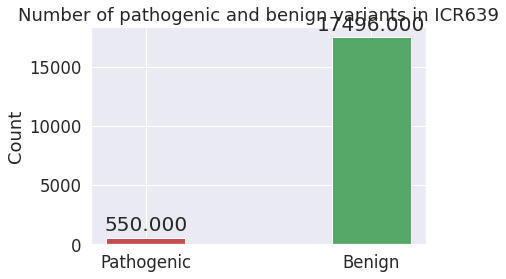

In [ ]:
# Proportions of Pathogenic and Benign in Clinvitae 2019
bars = ('Pathogenic', 'Benign')
y_pos = np.arange(len(bars))


fig, ax = plt.subplots()
rect = ax.bar(y_pos, list(Counter(y_true_icr639commonvar).values())[::-1],
        width=0.35,
        color=['r', 'g'])
ax.set_ylabel('Count')
ax.set_title('Number of pathogenic and benign variants in ICR639')
plt.xticks(y_pos, bars)
autolabel(rect)
#plt.savefig('/Users/giovannanicora/Documents/evai_ml_paper/pubblication_data/icr639.png')
plt.show()

In [ ]:
scoring = {'accuracy_score': make_scorer(accuracy_score),
           'precision_score': make_scorer(precision_score),
           'roc_auc_score': make_scorer(roc_auc_score), 'f1_score': make_scorer(f1_score),
           'recall': make_scorer(recall_score),  # Sensibility, tpr
           'balanced_accuracy_score': make_scorer(balanced_accuracy_score),
           'matthews_corrcoef': make_scorer(matthews_corrcoef),
           'confusion_matrix': make_scorer(confusion_matrix),
           'average_precision_score': make_scorer(average_precision_score)}

vvp_scores = get_metrics_frompred(y_true_icr639commonvar, ypred_vvp, scoring)
cadd_scores = get_metrics_frompred(y_true_icr639commonvar, ypred_cadd, scoring)
evai_scores = get_metrics_frompred(y_true_icr639commonvar, ypred_evai, scoring)
bayes_scores = get_metrics_frompred(y_true_icr639commonvar, ypred_bayes, scoring)
lrA_scores = get_metrics_frompred(y_true_icr639commonvar, ypred_icr639_A, scoring)
lrB_scores = get_metrics_frompred(y_true_icr639commonvar, ypred_icr639_B, scoring)

res_icr639 = pd.concat((pd.DataFrame.from_dict(cadd_scores.items()),
                          pd.DataFrame.from_dict(vvp_scores.values()),
                          pd.DataFrame.from_dict(evai_scores.values()),
                          pd.DataFrame.from_dict(bayes_scores.values()),
                          pd.DataFrame.from_dict(lrA_scores.values()),
                          pd.DataFrame.from_dict(lrB_scores.values()),
                          ),
                         axis=1)

res_icr639.columns = ['Metric','Cadd','VVP', 'PS','Bayes', 'LogA', 'LogB']
res_icr639

,Metric,Cadd,VVP,PS,Bayes,LogA,LogB
0,accuracy_score,0.933891,0.602793,0.982766,0.99069,0.973845,0.981492
1,precision_score,0.308289,0.0710397,0.640754,0.785928,0.538235,0.622727
2,roc_auc_score,0.93685,0.793392,0.985829,0.973186,0.985631,0.988694
3,f1_score,0.464302,0.132623,0.777698,0.862069,0.699363,0.766434
4,recall,0.94,0.996364,0.989091,0.954545,0.998182,0.996364
5,balanced_accuracy_score,0.93685,0.793392,0.985829,0.973186,0.985631,0.988694
6,matthews_corrcoef,0.517291,0.203891,0.788831,0.861637,0.722987,0.780085
7,confusion_matrix,"[[16336, 1160], [33, 517]]","[[10330, 7166], [2, 548]]","[[17191, 305], [6, 544]]","[[17353, 143], [25, 525]]","[[17025, 471], [1, 549]]","[[17164, 332], [2, 548]]"
8,average_precision_score,0.29162,0.0708922,0.634096,0.751589,0.537312,0.620574


**LR-A Confusion Matrix** (C_00 -> TN, C_01 -> FP, C_10 -> FN, C_11 -> TP 

In [ ]:
pd.DataFrame(lrA_scores['confusion_matrix'], columns=['Predicted_Benign', 'Predicted_Pathogenic'],
             index=['Benign', 'Pathogenic']) 

,Predicted_Benign,Predicted_Pathogenic
Benign,17025,471
Pathogenic,1,549


**LR-B Confusion Matrix**

In [ ]:
pd.DataFrame(lrB_scores['confusion_matrix'], columns=['Predicted_Benign', 'Predicted_Pathogenic'],
             index=['Benign', 'Pathogenic']) 

,Predicted_Benign,Predicted_Pathogenic
Benign,17164,332
Pathogenic,2,548


**PS Confusion Matrix**

In [ ]:
pd.DataFrame(evai_scores['confusion_matrix'], columns=['Predicted_Benign', 'Predicted_Pathogenic'],
             index=['Benign', 'Pathogenic']) 

,Predicted_Benign,Predicted_Pathogenic
Benign,17191,305
Pathogenic,6,544


**Bayes Confusion Matrix**

In [ ]:
pd.DataFrame(bayes_scores['confusion_matrix'], columns=['Predicted_Benign', 'Predicted_Pathogenic'],
             index=['Benign', 'Pathogenic']) 

,Predicted_Benign,Predicted_Pathogenic
Benign,17353,143
Pathogenic,25,525


**CADD Confusion Matrix**

In [ ]:
pd.DataFrame(cadd_scores['confusion_matrix'], columns=['Predicted_Benign', 'Predicted_Pathogenic'],
             index=['Benign', 'Pathogenic']) 

,Predicted_Benign,Predicted_Pathogenic
Benign,16336,1160
Pathogenic,33,517


**VVP Confusion Matrix**

In [ ]:
pd.DataFrame(vvp_scores['confusion_matrix'], columns=['Predicted_Benign', 'Predicted_Pathogenic'],
             index=['Benign', 'Pathogenic']) 

,Predicted_Benign,Predicted_Pathogenic
Benign,10330,7166
Pathogenic,2,548


**Comparison with ACMG/AMP Classification**

Let's see how many VUS cases are solved

In [ ]:
acmg_class_icr639 = get_acmg_classification(icr639_df_commonvar)

print(Counter(acmg_class_icr639)['VUS'] + Counter(acmg_class_icr639)['VUS conflict'])

# Find VUS variants
iVUS_icr639 = [i for i in range(len(acmg_class_icr639)) if 'VUS' in acmg_class_icr639[i]]

print("Number of VUS in ICR639", len(iVUS_icr639))





11862
Number of VUS in ICR639 11862


In [ ]:
counter_acmg_icr = Counter(acmg_class_icr639)
print('Number of VUS:', counter_acmg_icr['VUS'] + counter_acmg_icr['VUS conflict'])
print('Number of Pathogenic:', counter_acmg_icr['P'])
print('Number of Likely pathogenic:', counter_acmg_icr['LP'])
print('Number of Likely Benign:', counter_acmg_icr['LB'])
print('Number of Benign:', counter_acmg_icr['B'])

Number of VUS: 11862
Number of Pathogenic: 512
Number of Likely pathogenic: 156
Number of Likely Benign: 2097
Number of Benign: 3419


In [ ]:
# Conflict variants true classification
counter_acmg_icr['VUS conflict']

4

In [ ]:
ninterp = np.sum([counter_acmg_icr['P'], counter_acmg_icr['LP'], counter_acmg_icr['LB'], counter_acmg_icr['B']])
print('Number of interpreted variants wbith ACMG/AMP rules:'+
     str(ninterp)+' ('+str(ninterp/len(acmg_class_icr639))+'% of total variants)')

Number of interpreted variants wbith ACMG/AMP rules:6184 (0.34267981824226973% of total variants)


In [ ]:
# Benign and Pathogenic variants interpreted as P from ACMG/AMP final rules
bp_interpreted_patho = Counter([x for i,x in enumerate(y_true_icr639commonvar) if acmg_class_icr639[i]=='P'])
bp_interpreted_patho

Counter({0: 83, 1: 429})

In [ ]:
# Benign and Pathogenic variants interpreted as LP from ACMG/AMP final rules
bp_interpreted_likelypatho = Counter([x for i,x in enumerate(y_true_icr639commonvar) if acmg_class_icr639[i]=='LP'])
bp_interpreted_likelypatho

Counter({0: 61, 1: 95})

In [ ]:
# Precision of ACMG/AMP rules in LP/P:
(bp_interpreted_patho[1]+bp_interpreted_likelypatho[1])/(np.sum([x for x in bp_interpreted_patho.values()])+np.sum([x for x in bp_interpreted_likelypatho.values()]))

0.7844311377245509

In [ ]:
vvp_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_true_icr639commonvar) if i in iVUS_icr639],
                                        [x for i,x in enumerate(ypred_vvp) if i in iVUS_icr639],
                                        scoring)
cadd_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_true_icr639commonvar) if i in iVUS_icr639], 
                                         [x for i,x in enumerate(ypred_cadd) if i in iVUS_icr639], 
                                         scoring)
evai_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_true_icr639commonvar) if i in iVUS_icr639], 
                                         [x for i,x in enumerate(ypred_evai) if i in iVUS_icr639], 
                                         scoring)
bayes_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_true_icr639commonvar) if i in iVUS_icr639],
                                          [x for i,x in enumerate(ypred_bayes) if i in iVUS_icr639], 
                                          scoring)
lrA_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_true_icr639commonvar) if i in iVUS_icr639], 
                                        [x for i,x in enumerate(ypred_icr639_A) if i in iVUS_icr639], 
                                        scoring)
lrB_scores_onvus = get_metrics_frompred([x for i,x in enumerate(y_true_icr639commonvar) if i in iVUS_icr639], 
                                        [x for i,x in enumerate(ypred_icr639_B) if i in iVUS_icr639], 
                                        scoring)

res_icr639_onvus = pd.concat((pd.DataFrame.from_dict(cadd_scores_onvus.items()),
                          pd.DataFrame.from_dict(vvp_scores_onvus.values()),
                          pd.DataFrame.from_dict(evai_scores_onvus.values()),
                          pd.DataFrame.from_dict(bayes_scores_onvus.values()),
                          pd.DataFrame.from_dict(lrA_scores_onvus.values()),
                          pd.DataFrame.from_dict(lrB_scores_onvus.values()),
                          ),
                         axis=1)

res_icr639_onvus.columns = ['Metric','Cadd','VVP', 'PS','Bayes', 'LogA', 'LogB']
res_icr639_onvus

,Metric,Cadd,VVP,PS,Bayes,LogA,LogB
0,accuracy_score,0.936351,0.465352,0.987102,0.996712,0.97336,0.983982
1,precision_score,0.0247718,0.00408291,0.11976,0.259259,0.0735294,0.113208
2,roc_auc_score,0.833786,0.732089,0.878406,0.633771,0.967462,0.953597
3,f1_score,0.0479193,0.00813262,0.207254,0.264151,0.136612,0.201681
4,recall,0.730769,1,0.769231,0.269231,0.961538,0.923077
5,balanced_accuracy_score,0.833786,0.732089,0.878406,0.633771,0.967462,0.953597
6,matthews_corrcoef,0.126948,0.0435338,0.300413,0.262551,0.262037,0.320227
7,confusion_matrix,"[[11088, 748], [7, 19]]","[[5494, 6342], [0, 26]]","[[11689, 147], [6, 20]]","[[11816, 20], [19, 7]]","[[11521, 315], [1, 25]]","[[11648, 188], [2, 24]]"
8,average_precision_score,0.0186926,0.00408291,0.0926293,0.0714023,0.0707857,0.104668


In [ ]:
lrA_scores_onvus['confusion_matrix'][0,0]+lrA_scores_onvus['confusion_matrix'][1,1]

11546

In [ ]:
# Spec A
lrA_scores_onvus['confusion_matrix'][0,0]/(lrA_scores_onvus['confusion_matrix'][0,0]+lrA_scores_onvus['confusion_matrix'][0,1])

0.973386279148361

In [ ]:
# Spec B
lrB_scores_onvus['confusion_matrix'][0,0]/(lrB_scores_onvus['confusion_matrix'][0,0]+lrB_scores_onvus['confusion_matrix'][0,1])

0.9841162554917202

In [ ]:
# Spec Bayes
bayes_scores_onvus['confusion_matrix'][0,0]/(bayes_scores_onvus['confusion_matrix'][0,0]+bayes_scores_onvus['confusion_matrix'][0,1])

0.9983102399459277

In [ ]:
# PS
evai_scores_onvus['confusion_matrix'][0,0]/(evai_scores_onvus['confusion_matrix'][0,0]+evai_scores_onvus['confusion_matrix'][0,1])

0.9875802636025685

### Find out where the misclassified variants occur in the genome

In [ ]:
genes_in_train_df = pd.read_csv(ROOT_PATH + 'pubblication_data/clinvitae2017/genes_in_train.tsv', 
                             sep='\t')
genes_in_train_df.head()

,GENE,NBEN,NPATHO,PERCBEN,PERCPATHO
0,DMD,84,187,0.309963,0.690037
1,ENG,27,162,0.142857,0.857143
2,MEN1,3,106,0.027523,0.972477
3,ACVRL1,11,103,0.096491,0.903509
4,BRCA2,37,85,0.303279,0.696721


In [ ]:
train_genes = genes_in_train_df.GENE.values

In [ ]:
icr639_var = pd.read_csv(ROOT_PATH + 'pubblication_data/icr639/allvar_genes_icr639.tsv',
                         sep='\t', header=None)

icr639_var.columns = kcol+['GENE']
icr639_var['CHROMOSOME'] = 'chr'+icr639_var['CHROMOSOME']

In [ ]:
icr639_genes = pd.merge(icr639_df_commonvar[kcol], icr639_var, left_on=kcol, right_on=kcol)

In [ ]:
# LR-A
# FP and FN
i_lra_fp = [i for i,x in enumerate(y_true_icr639commonvar) if (x==0 and ypred_icr639_A[i]==1) ]
i_lra_fn = [i for i,x in enumerate(y_true_icr639commonvar) if (x==1 and ypred_icr639_A[i]==0) ]

In [ ]:
# TN and FP
i_lra_tn = [i for i,x in enumerate(y_true_icr639commonvar) if (x==0 and ypred_icr639_A[i]==0) ]
i_lra_tp = [i for i,x in enumerate(y_true_icr639commonvar) if (x==1 and ypred_icr639_A[i]==1) ]

In [ ]:
a_fp_var = icr639_df_commonvar.iloc[i_lra_fp][kcol]
a_fn_var = icr639_df_commonvar.iloc[i_lra_fn][kcol]

a_fn_var_gene = pd.merge(a_fn_var, icr639_genes, left_on=kcol, right_on=kcol)
a_fp_var_gene = pd.merge(a_fp_var, icr639_genes, left_on=kcol, right_on=kcol)


In [ ]:
a_tp_var = icr639_df_commonvar.iloc[i_lra_tp][kcol]
a_tn_var = icr639_df_commonvar.iloc[i_lra_tn][kcol]

a_tn_var_gene = pd.merge(a_tn_var, icr639_genes, left_on=kcol, right_on=kcol)
a_tp_var_gene = pd.merge(a_tp_var, icr639_genes, left_on=kcol, right_on=kcol)



In [ ]:
Counter(a_fn_var_gene['GENE'])

Counter({'NF1': 1})

In [ ]:
Counter(a_fp_var_gene['GENE'])

Counter({'AC008738.1': 2,
         'AC092143.1': 2,
         'ALDH2': 2,
         'ALK': 12,
         'APC': 6,
         'ATM': 8,
         'BACH1': 1,
         'BARD1': 1,
         'BIVM-ERCC5': 2,
         'BLM': 2,
         'BMPR1A': 2,
         'BRCA1': 19,
         'BRCA2': 34,
         'BRIP1': 3,
         'BUB1B': 5,
         'C11orf65': 5,
         'CDH1': 4,
         'CDK4': 3,
         'CDKN1B': 1,
         'CDKN1C': 7,
         'CDKN2A': 3,
         'CEBPA': 2,
         'CHEK2': 4,
         'CHRNA3': 1,
         'CTC-554D6.1': 4,
         'CTD-2135D7.2': 1,
         'CTD-2196E14.3': 2,
         'CTD-2517M22.17': 3,
         'CYLD': 5,
         'DDB2': 2,
         'DICER1': 2,
         'DIS3L2': 4,
         'EGFR': 10,
         'EGFR-AS1': 1,
         'EPCAM': 1,
         'ERCC2': 8,
         'ERCC3': 5,
         'ERCC4': 2,
         'ERCC5': 5,
         'EXT1': 12,
         'EXT2': 8,
         'EZH2': 1,
         'FANCC': 1,
         'FANCD2': 13,
         'FANCD2OS': 7,
   

In [ ]:
print('LR-A')
print('Genes with FP variants:'+str(len(list(set(a_fp_var_gene.GENE.values)))))
print('Genes with FP variants that are not included in the training set:'+
        str(len(np.setdiff1d(a_fp_var_gene.GENE.values, train_genes))))
print('Genes with FN variants:'+str(len(list(set(a_fn_var_gene.GENE.values)))))
print('Genes with FN variants that are not included in the training set:'+
        str(len(np.setdiff1d(a_fn_var_gene.GENE.values, train_genes))))

print('Genes with TP variants:'+str(len(list(set(a_tp_var_gene.GENE.values)))))
print('Genes with TP variants that are not included in the training set:'+
        str(len(np.setdiff1d(a_tp_var_gene.GENE.values, train_genes))))
print('Genes with TN variants:'+str(len(list(set(a_tn_var_gene.GENE.values)))))
print('Genes with TN variants that are not included in the training set:'+
        str(len(np.setdiff1d(a_tn_var_gene.GENE.values, train_genes))))

LR-A
Genes with FP variants:119
Genes with FP variants that are not included in the training set:64
Genes with FN variants:1
Genes with FN variants that are not included in the training set:1
Genes with TP variants:35
Genes with TP variants that are not included in the training set:6
Genes with TN variants:324
Genes with TN variants that are not included in the training set:253


In [ ]:
d = pd.merge(genes_in_train_df, a_fp_var_gene.GENE, left_on='GENE', right_on='GENE').drop_duplicates()

In [ ]:
d

,GENE,NBEN,NPATHO,PERCBEN,PERCPATHO
0,MEN1,3,106,0.027523,0.972477
2,BRCA2,37,85,0.303279,0.696721
36,BRCA1,30,74,0.288462,0.711538
55,SMAD4,2,49,0.039216,0.960784
56,RET,15,34,0.306122,0.693878
59,APC,9,19,0.321429,0.678571
65,FH,3,18,0.142857,0.857143
70,CTC-554D6.1,8,17,0.320000,0.680000
74,RP11-45M22.4,10,17,0.370370,0.629630
75,FLCN,10,17,0.370370,0.629630


In [ ]:
d['SUM'] = d['NBEN']+d['NPATHO']

d = d.sort_values(by='SUM', ascending=False)
d['Count'] = range(d.shape[0])

In [ ]:
d

,GENE,NBEN,NPATHO,PERCBEN,PERCPATHO,SUM,Count
2,BRCA2,37,85,0.303279,0.696721,122,0
0,MEN1,3,106,0.027523,0.972477,109,1
36,BRCA1,30,74,0.288462,0.711538,104,2
55,SMAD4,2,49,0.039216,0.960784,51,3
56,RET,15,34,0.306122,0.693878,49,4
107,RECQL4,22,7,0.758621,0.241379,29,5
59,APC,9,19,0.321429,0.678571,28,6
75,FLCN,10,17,0.370370,0.629630,27,7
74,RP11-45M22.4,10,17,0.370370,0.629630,27,8
122,NSD1,20,5,0.800000,0.200000,25,9


In [ ]:
pd.merge(genes_in_train_df, a_fn_var_gene.GENE, left_on='GENE', right_on='GENE').drop_duplicates()

,GENE,NBEN,NPATHO,PERCBEN,PERCPATHO


In [ ]:
d = pd.merge(genes_in_train_df, a_fp_var_gene.GENE, left_on='GENE', right_on='GENE').drop_duplicates()

In [ ]:
d

,GENE,NBEN,NPATHO,PERCBEN,PERCPATHO
0,MEN1,3,106,0.027523,0.972477
2,BRCA2,37,85,0.303279,0.696721
36,BRCA1,30,74,0.288462,0.711538
55,SMAD4,2,49,0.039216,0.960784
56,RET,15,34,0.306122,0.693878
59,APC,9,19,0.321429,0.678571
65,FH,3,18,0.142857,0.857143
70,CTC-554D6.1,8,17,0.320000,0.680000
74,RP11-45M22.4,10,17,0.370370,0.629630
75,FLCN,10,17,0.370370,0.629630


In [ ]:
d['SUM'] = d['NBEN']+d['NPATHO']

d = d.sort_values(by='SUM', ascending=False)
d['Count'] = range(d.shape[0])

In [ ]:
d

,GENE,NBEN,NPATHO,PERCBEN,PERCPATHO,SUM,Count
2,BRCA2,37,85,0.303279,0.696721,122,0
0,MEN1,3,106,0.027523,0.972477,109,1
36,BRCA1,30,74,0.288462,0.711538,104,2
55,SMAD4,2,49,0.039216,0.960784,51,3
56,RET,15,34,0.306122,0.693878,49,4
107,RECQL4,22,7,0.758621,0.241379,29,5
59,APC,9,19,0.321429,0.678571,28,6
75,FLCN,10,17,0.370370,0.629630,27,7
74,RP11-45M22.4,10,17,0.370370,0.629630,27,8
122,NSD1,20,5,0.800000,0.200000,25,9


In [ ]:
pd.merge(genes_in_train_df, a_fn_var_gene.GENE, left_on='GENE', right_on='GENE').drop_duplicates()

,GENE,NBEN,NPATHO,PERCBEN,PERCPATHO


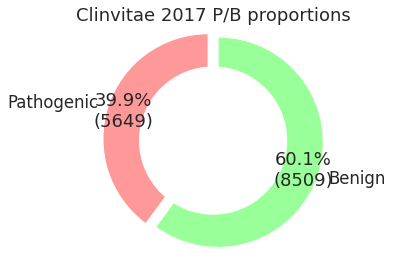

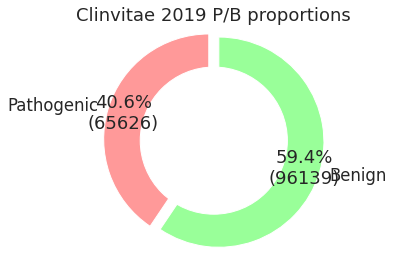

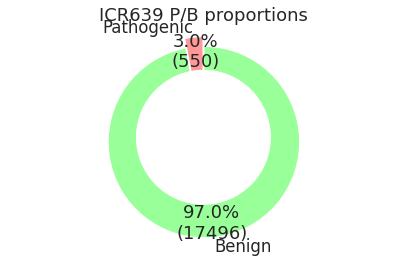

In [ ]:
# Nested Pie charts
labels = ['Pathogenic', 'Benign']

n_patho_clin2017 = np.sum(patho_count)
n_patho_clin2019 = Counter(y_c2019_only)[1]
n_patho_icr = Counter(y_true_icr639commonvar)[1]

n_ben_clin2017 = np.sum(ben_count)
n_ben_clin2019 = Counter(y_c2019_only)[0]
n_ben_icr = Counter(y_true_icr639commonvar)[0]

sizes = [np.sum([n_patho_clin2017, n_patho_clin2019, n_patho_icr]),
         np.sum([n_ben_clin2017, n_ben_clin2019, n_ben_icr])]

sizes_c2017 = [n_patho_clin2017, n_ben_clin2017]
sizes_c2019 = [n_patho_clin2019, n_ben_clin2019]
sizes_icr = [n_patho_icr, n_ben_icr]

colors = ['#ff9999', '#99ff99']

#explsion
explode = (0.05,0.05)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)




fig, ax = plt.subplots()
plt.pie(sizes_c2017, colors=colors, labels=labels, autopct=lambda pct: func(pct, sizes_c2017), startangle=90, pctdistance=0.85, explode=explode)
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
ax.set_title('Clinvitae 2017 P/B proportions')
plt.tight_layout()
#plt.savefig('/Users/giovannanicora/Documents/evai_ml_paper/pubblication_data/clin2017_prop.png')

plt.show()

fig, ax = plt.subplots()
plt.pie(sizes_c2019, colors=colors, labels=labels, autopct=lambda pct: func(pct, sizes_c2019), startangle=90, pctdistance=0.85, explode=explode)
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
ax.set_title('Clinvitae 2019 P/B proportions')
plt.tight_layout()
#plt.savefig('/Users/giovannanicora/Documents/evai_ml_paper/pubblication_data/clin2019_prop.png')
plt.show()


fig, ax = plt.subplots()
plt.pie(sizes_icr, colors=colors, labels=labels, autopct=lambda pct: func(pct, sizes_icr), startangle=90, pctdistance=0.85, explode=explode)
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
ax.set_title('ICR639 P/B proportions')
plt.tight_layout()
#fig('/Users/giovannanicora/Documents/evai_ml_paper/pubblication_data/icr_prop.png')
plt.show()


# References
[1] Flygare, S., Hernandez, E.J., Phan, L. et al. The VAAST Variant Prioritizer (VVP): ultrafast, easy to use whole genome variant prioritization tool. BMC Bioinformatics 19, 57 (2018). https://doi.org/10.1186/s12859-018-2056-y

[2] Rentzsch P, Witten D, Cooper GM, Shendure J, Kircher M.
 CADD: predicting the deleteriousness of variants throughout the human genome.
 Nucleic Acids Res. 2018 Oct 29. doi: 10.1093/nar/gky1016.
 PubMed PMID: 30371827. 

 [3] Nicora G, Limongelli I, Gambelli P, Memmi M, Malovini A, Mazzanti A, Napolitano C, Priori S, Bellazzi R.
 Hum Mutat. 2018 Dec;39(12):1835-1846. doi: 10.1002/humu.23665. Epub 2018 Oct 19.PMID:30298955
 
 [4] Mahamdallie S, Ruark E, Holt E, Poyastro-Pearson E, Renwick A, Strydom A, et al. The ICR639 CPG NGS validation series: A resource to assess analytical sensitivity of cancer predisposition gene testing. Wellcome Open Res. 2018;3:68.
 
 [5] Tavtigian SV, Greenblatt MS, Harrison SM, Nussbaum RL, Prabhu SA, Boucher KM, 
 Biesecker LG; ClinGen Sequence Variant Interpretation Working Group (ClinGen
 SVI). Modeling the ACMG/AMP variant classification guidelines as a Bayesian
 classification framework. Genet Med. 2018 Sep;20(9):1054-1060. doi:
 10.1038/gim.2017.210. Epub 2018 Jan 4. PubMed PMID: 29300386; PubMed Central
 PMCID: PMC6336098.